### DoRothEA VS CollecTRI

&emsp;&emsp;&emsp;



<br></br>

### **Data Preparation**

In [5]:
# # Install necessary libraries
# %pip install scanpy
# %pip install decoupler
# %pip install pydeseq2
# %pip install adjustText
# %pip install omnipath
# %pip install matplotlib-venn

<!-- # Install necessary libraries
%pip install scanpy
%pip install decoupler
%pip install pydeseq2
%pip install adjustText
%pip install omnipath -->

In [6]:
# Import Necessary libraries
import scanpy as sc
import decoupler as dc
import omnipath as op

# Data Manipulation
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy import stats

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Differential Expression Analysis (DESeq2)
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


import warnings
warnings.filterwarnings("ignore")

import os
if not os.path.exists("datasets"):
    os.makedirs("datasets")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
# Retrieve CollecTRI gene regulatory network
try:
    collectri = dc.get_collectri(organism='human', split_complexes=False)
    collectri.to_csv("datasets/collectri.csv",index=False)
except:
    collectri = pd.read_table("datasets/collectri.csv", sep=',')
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [8]:
# Retrieve DoRothEA gene regulatory network
try:
    dorothea = dc.get_dorothea(organism='human')
    dorothea.to_csv("datasets/dorothea.csv",index=False)
    dorothea_sign = dorothea.copy()
    dorothea_sign['weight'] = np.sign(dorothea_sign['weight'])
    dorothea_sign.to_csv("datasets/dorothea_sign.csv",index=False)
except:
    dorothea = pd.read_table("datasets/dorothea.csv", sep=',')
    dorothea_sign = dorothea.copy()
    dorothea_sign['weight'] = np.sign(dorothea_sign['weight'])
dorothea

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


In [9]:
# Read raw data and process it
df_tgfb = pd.read_csv('datasets/counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
df_tgfb

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


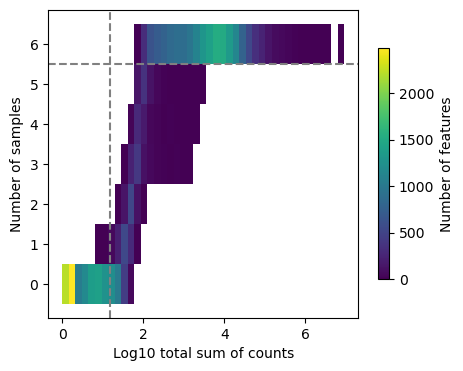

In [10]:
# Pre-processing TGFb dataset

# Transform to AnnData object
adata = AnnData(df_tgfb, dtype=np.float32)
adata.var_names_make_unique()

# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Quality Control (optional but recommended)
# --- only the genes in the upper-right corner are going to be kept
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata_filtered = adata[:, genes].copy()

# Normalize total-count per million, CPM (library-size correct)
sc.pp.normalize_total(adata_filtered, target_sum=1e6)

# Store normalized counts in layers
adata_filtered.layers['cpm'] = adata_filtered.X
adata_filtered.X = adata_filtered.layers['counts']

In [11]:
# Download GSE186341 Data
df_gse186341 = pd.read_csv("datasets/GSE186341__deresults_deseqfiltered.csv", sep=",", index_col=0).T
df_gse186341

ID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DU145_AZD5363_v_DU145_DMSO,NaN,1.388290,NaN,NaN,NaN,NaN,NaN,NaN,-0.685083,NaN,...,0.626731,0.752848,NaN,-1.367168,-0.493515,0.235048,-0.752776,-2.496335,-1.034335,0.457740
PANC1_AFATINIB_v_PANC1_DMSO,NaN,0.397981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.742715,-1.219882,NaN,NaN,-1.562164,NaN,0.554136,0.836142,0.869692,-0.240313
HCC1143_TIVANTINIB_v_HCC1143_DMSO,NaN,-0.489952,NaN,NaN,NaN,NaN,NaN,NaN,0.457873,NaN,...,0.273729,0.103023,NaN,NaN,0.723085,NaN,0.153537,-0.521075,0.272643,0.667981
PANC1_CRIZOTINIB_v_PANC1_DMSO,NaN,2.251490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.624936,-0.000303,NaN,NaN,0.724345,NaN,0.516557,-0.882671,0.381799,0.455217
PANC1_MK2206_v_PANC1_DMSO,NaN,-0.552421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.797144,0.061272,NaN,NaN,1.443461,NaN,-0.163740,0.519291,0.782504,-0.080141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U87_ICOTINIB_v_U87_DMSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.981341,-1.058985,NaN,NaN,NaN,NaN,2.415272,-0.707890,-0.701863,0.009879
HCC1143_AZD5363_v_HCC1143_DMSO,NaN,-1.519386,NaN,NaN,NaN,NaN,NaN,NaN,-0.131585,NaN,...,-2.465480,-0.905809,NaN,NaN,-0.636081,NaN,1.302778,0.750566,0.924691,0.732722
HF2597_MK2206_v_HF2597_DMSO,2.023806,0.280534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.909432,-0.373079,NaN,-1.189409,0.367076,NaN,0.668076,0.374469,-0.427420,0.397206
PANC1_BOSUTINIB_v_PANC1_DMSO,NaN,-0.099218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.944181,0.168055,NaN,NaN,1.299756,NaN,0.085410,0.766960,-0.513396,0.453244


### **TF Calculation**

#### Calculate the TF activity

In [12]:
# Convert anndata to dataframe
mat = adata_filtered.to_df(layer='cpm')

# Run the function for collectri
df_tgfb_collectri_acts, df_tgfb_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)

# Run the function for dorothea
df_tgfb_dorothea_acts, df_tgfb_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea_sign, verbose=True)

Running ulm on mat with 6 samples and 17575 targets for 629 sources.
Running ulm on mat with 6 samples and 17575 targets for 281 sources.


In [13]:
# Run Differential Expression Analysis

# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata_filtered,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between treatment vs normal
stat_res = DeseqStats(dds, contrast=["condition", 'treatment', 'control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_treatment_vs_control')

# Extract results
results_df = stat_res.results_df

# Obtain gene level statistics to perform enrichment analysis
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})

# Run TF activity
df_dea_collectri_acts, df_dea_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
df_dea_dorothea_acts, df_dea_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea_sign, verbose=True)

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 86.67 seconds.

Fitting dispersion trend curve...
... done in 5.97 seconds.

Fitting MAP dispersions...
... done in 87.15 seconds.

Fitting LFCs...
... done in 5.27 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: condition treatment vs control


... done in 2.73 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.067095,0.294314,0.227970,0.819669,0.872006
RP11-34P13.8,29.560568,-0.086227,0.249617,-0.345438,0.729765,0.802103
CICP27,106.257057,0.144798,0.177248,0.816925,0.413971,0.523016
FO538757.2,33.114796,-0.640164,0.348935,-1.834621,0.066562,0.113388
AP006222.2,67.154701,0.577477,0.282791,2.042061,0.041145,0.074550
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.445816,0.278378,-1.601475,0.109272,0.174333
MT-TE,1284.633179,-0.343227,0.287943,-1.191996,0.233263,0.329417
MT-CYB,55097.121094,-0.323882,0.302438,-1.070903,0.284213,0.387754


Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition treatment vs control


... done in 12.47 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050389,0.271469,0.227970,0.819669,0.872006
RP11-34P13.8,29.560568,-0.068934,0.234593,-0.345438,0.729765,0.802103
CICP27,106.257057,0.129352,0.172298,0.816925,0.413971,0.523016
FO538757.2,33.114796,-0.480453,0.337199,-1.834621,0.066562,0.113388
AP006222.2,67.154701,0.473818,0.277521,2.042061,0.041145,0.074550
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240865,0.260504,-1.601475,0.109272,0.174333
MT-TE,1284.633179,-0.265303,0.273086,-1.191996,0.233263,0.329417
MT-CYB,55097.121094,-0.523030,0.297745,-1.070903,0.284213,0.387754


Running ulm on mat with 1 samples and 17575 targets for 629 sources.
Running ulm on mat with 1 samples and 17575 targets for 281 sources.


In [14]:
# Create empty dataframes for storing results
df_collectri_acts = pd.DataFrame()
df_collectri_pvals = pd.DataFrame()
df_dorothea_acts = pd.DataFrame()
df_dorothea_pvals = pd.DataFrame()

# Loop through each row of df_gse186341
for _, row in df_gse186341.iterrows():
    # Drop NaN values
    mat = row.dropna().to_frame().T  # Convert series back to DataFrame with dropped NaN
    
    # Run the function for collectri
    tf_collectri_acts, tf_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
    
    # Run the function for dorothea
    tf_dorothea_acts, tf_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea, verbose=True)
    
    # Append results to the respective dataframes
    df_collectri_acts = pd.concat([df_collectri_acts, tf_collectri_acts], axis=0)
    df_collectri_pvals = pd.concat([df_collectri_pvals, tf_collectri_pvals], axis=0)
    df_dorothea_acts = pd.concat([df_dorothea_acts, tf_dorothea_acts], axis=0)
    df_dorothea_pvals = pd.concat([df_dorothea_pvals, tf_dorothea_pvals], axis=0)


Running ulm on mat with 1 samples and 11319 targets for 573 sources.
Running ulm on mat with 1 samples and 11319 targets for 276 sources.
Running ulm on mat with 1 samples and 10862 targets for 572 sources.
Running ulm on mat with 1 samples and 10862 targets for 280 sources.
Running ulm on mat with 1 samples and 11818 targets for 622 sources.
Running ulm on mat with 1 samples and 11818 targets for 283 sources.
Running ulm on mat with 1 samples and 10837 targets for 572 sources.
Running ulm on mat with 1 samples and 10837 targets for 280 sources.
Running ulm on mat with 1 samples and 10857 targets for 575 sources.
Running ulm on mat with 1 samples and 10857 targets for 280 sources.
Running ulm on mat with 1 samples and 11890 targets for 612 sources.
Running ulm on mat with 1 samples and 11890 targets for 283 sources.
Running ulm on mat with 1 samples and 10162 targets for 535 sources.
Running ulm on mat with 1 samples and 10162 targets for 275 sources.
Running ulm on mat with 1 samples 

In [15]:
# Drop column that has a NAN value
def drop_nan_tf(df_acts,df_pvals):
    list_of_columns = df_acts.dropna(axis=1).columns
    return df_acts[list_of_columns], df_pvals[list_of_columns]

df_collectri_acts, df_collectri_pvals = drop_nan_tf(df_collectri_acts, df_collectri_pvals)
df_dorothea_acts, df_dorothea_pvals = drop_nan_tf(df_dorothea_acts, df_dorothea_pvals)
df_tgfb_collectri_acts, df_tgfb_collectri_pvals = drop_nan_tf(df_tgfb_collectri_acts, df_tgfb_collectri_pvals)
df_tgfb_dorothea_acts, df_tgfb_dorothea_pvals = drop_nan_tf(df_tgfb_dorothea_acts, df_tgfb_dorothea_pvals)
df_dea_collectri_acts, df_dea_collectri_pvals = drop_nan_tf(df_dea_collectri_acts, df_dea_collectri_pvals)
df_dea_dorothea_acts, df_dea_dorothea_pvals = drop_nan_tf(df_dea_dorothea_acts, df_dea_dorothea_pvals)

print("-- TFs without NAN columns --")
print("GSE186341-CollecTRI:",df_collectri_acts.shape)
print("GSE186341-DoRothEA:",df_dorothea_acts.shape)
print("TGFb-CollecTRI: ",df_tgfb_collectri_acts.shape)
print("TGFb-DoRothEA: ",df_tgfb_dorothea_acts.shape)
print("TGFb-DEA-CollecTRI: ",df_dea_collectri_acts.shape)
print("TGFb-DEA-DoRothEA: ",df_dea_dorothea_acts.shape)

-- TFs without NAN columns --
GSE186341-CollecTRI: (352, 466)
GSE186341-DoRothEA: (352, 268)
TGFb-CollecTRI:  (6, 629)
TGFb-DoRothEA:  (6, 281)
TGFb-DEA-CollecTRI:  (1, 629)
TGFb-DEA-DoRothEA:  (1, 281)


In [16]:
# Filter p-value < 0.05 in TF activity
tf_collectri_acts_filtered = df_collectri_acts.loc[:, df_collectri_pvals.lt(0.05).all()]
tf_dorothea_acts_filtered = df_dorothea_acts.loc[:, df_dorothea_pvals.lt(0.05).all()]

df_tgfb_collectri_acts_filtered = df_tgfb_collectri_acts.loc[:, df_tgfb_collectri_pvals.lt(0.05).all()]
df_tgfb_dorothea_acts_filtered = df_tgfb_dorothea_acts.loc[:, df_tgfb_dorothea_pvals.lt(0.05).all()]
df_dea_collectri_acts_filtered = df_dea_collectri_acts.loc[:, df_dea_collectri_pvals.lt(0.05).all()]
df_dea_dorothea_acts_filtered = df_dea_dorothea_acts.loc[:, df_dea_dorothea_pvals.lt(0.05).all()]

df_tgfb_collectri_pvals_filtered = df_tgfb_collectri_pvals.loc[:, df_tgfb_collectri_pvals.lt(0.05).all()]
df_tgfb_dorothea_pvals_filtered = df_tgfb_dorothea_pvals.loc[:, df_tgfb_dorothea_pvals.lt(0.05).all()]
df_dea_collectri_pvals_filtered = df_dea_collectri_pvals.loc[:, df_dea_collectri_pvals.lt(0.05).all()]
df_dea_dorothea_pvals_filtered = df_dea_dorothea_pvals.loc[:, df_dea_dorothea_pvals.lt(0.05).all()]

print("-- Filtered by p-value < 0.05 --")
print("GSE186341-CollecTRI:",tf_collectri_acts_filtered.shape)
print("GSE186341-DoRothEA:",tf_dorothea_acts_filtered.shape)
print("TGFb-CollecTRI: ",df_tgfb_collectri_acts_filtered.shape)
print("TGFb-DoRothEA: ",df_tgfb_dorothea_acts_filtered.shape)
print("TGFb-DEA-CollecTRI: ",df_dea_collectri_acts_filtered.shape)
print("TGFb-DEA-DoRothEA: ",df_dea_dorothea_acts_filtered.shape)

-- Filtered by p-value < 0.05 --
GSE186341-CollecTRI: (352, 0)
GSE186341-DoRothEA: (352, 0)
TGFb-CollecTRI:  (6, 173)
TGFb-DoRothEA:  (6, 55)
TGFb-DEA-CollecTRI:  (1, 169)
TGFb-DEA-DoRothEA:  (1, 81)


#### Find Overlap TF

In [17]:
def find_overlap_tf(df_collectri_acts, df_collectri_pvals, df_dorothea_acts, df_dorothea_pvals):
    overlap_columns = df_collectri_acts.columns.intersection(df_dorothea_acts.columns)
    return df_collectri_acts[overlap_columns], df_collectri_pvals[overlap_columns], df_dorothea_acts[overlap_columns], df_dorothea_pvals[overlap_columns]

df_collectri_acts_overlap, df_collectri_pvals_overlap, df_dorothea_acts_overlap, df_dorothea_pvals_overlap = find_overlap_tf(df_collectri_acts, df_collectri_pvals, df_dorothea_acts, df_dorothea_pvals)
df_tgfb_collectri_acts_overlap, df_tgfb_collectri_pvals_overlap, df_tgfb_dorothea_acts_overlap, df_tgfb_dorothea_pvals_overlap = find_overlap_tf(df_tgfb_collectri_acts, df_tgfb_collectri_pvals, df_tgfb_dorothea_acts, df_tgfb_dorothea_pvals)
df_dea_collectri_acts_overlap, df_dea_collectri_pvals_overlap, df_dea_dorothea_acts_overlap, df_dea_dorothea_pvals_overlap = find_overlap_tf(df_dea_collectri_acts, df_dea_collectri_pvals, df_dea_dorothea_acts, df_dea_dorothea_pvals)
df_tgfb_collectri_acts_filtered_overlap, df_tgfb_collectri_pvals_filtered_overlap, df_tgfb_dorothea_acts_filtered_overlap, df_tgfb_dorothea_pvals_filtered_overlap = find_overlap_tf(df_tgfb_collectri_acts_filtered, df_tgfb_collectri_pvals_filtered, df_tgfb_dorothea_acts_filtered, df_tgfb_dorothea_pvals_filtered)
df_dea_collectri_acts_filtered_overlap, df_dea_collectri_pvals_filtered_overlap, df_dea_dorothea_acts_filtered_overlap, df_dea_dorothea_pvals_filtered_overlap = find_overlap_tf(df_dea_collectri_acts_filtered, df_dea_collectri_pvals_filtered, df_dea_dorothea_acts_filtered, df_dea_dorothea_pvals_filtered)

print("-- Count Overlap TFs --")
print("GSE186341-CollecTRI:",df_collectri_acts_overlap.shape)
print("GSE186341-DoRothEA:",df_dorothea_acts_overlap.shape)
print("TGFb-CollecTRI: ",df_tgfb_collectri_acts_overlap.shape)
print("TGFb-DoRothEA: ",df_tgfb_dorothea_acts_overlap.shape)
print("TGFb-DEA-CollecTRI: ",df_dea_collectri_acts_overlap.shape)
print("TGFb-DEA-DoRothEA: ",df_dea_dorothea_acts_overlap.shape)
print("TGFb-CollecTRI-FILTERED: ",df_tgfb_collectri_acts_filtered_overlap.shape)
print("TGFb-DoRothEA-FILTERED: ",df_tgfb_dorothea_acts_filtered_overlap.shape)
print("TGFb-DEA-CollecTRI-FILTERED: ",df_dea_collectri_acts_filtered_overlap.shape)
print("TGFb-DEA-DoRothEA-FILTERED: ",df_dea_dorothea_acts_filtered_overlap.shape)

-- Count Overlap TFs --
GSE186341-CollecTRI: (352, 210)
GSE186341-DoRothEA: (352, 210)
TGFb-CollecTRI:  (6, 241)
TGFb-DoRothEA:  (6, 241)
TGFb-DEA-CollecTRI:  (1, 241)
TGFb-DEA-DoRothEA:  (1, 241)
TGFb-CollecTRI-FILTERED:  (6, 33)
TGFb-DoRothEA-FILTERED:  (6, 33)
TGFb-DEA-CollecTRI-FILTERED:  (1, 36)
TGFb-DEA-DoRothEA-FILTERED:  (1, 36)


#### Calculate mean for TGFb dataset only overlap

In [18]:
def calculate_mean(df,n_control=3,n_treatment=3):
    control = pd.DataFrame(df.iloc[0:n_control,].mean()).T.rename(index={0:"control"})
    treatment = pd.DataFrame(df.iloc[n_control:n_control+n_treatment,].mean()).T.rename(index={0:"treatment"})
    return pd.concat([control, treatment])

df_tgfb_collectri_acts_overlap_mean  = calculate_mean(df_tgfb_collectri_acts_overlap)
df_tgfb_dorothea_acts_overlap_mean  = calculate_mean(df_tgfb_dorothea_acts_overlap)
df_tgfb_collectri_acts_filtered_overlap_mean  = calculate_mean(df_tgfb_collectri_acts_filtered_overlap)
df_tgfb_dorothea_acts_filtered_overlap_mean  = calculate_mean(df_tgfb_dorothea_acts_filtered_overlap)

print("-- Count Overlap TFs (mean only)--")
print("TGFb-CollecTRI: ",df_tgfb_collectri_acts_overlap_mean.shape)
print("TGFb-DoRothEA: ",df_tgfb_dorothea_acts_overlap_mean.shape)
print("TGFb-CollecTRI-FILTERED: ",df_tgfb_collectri_acts_filtered_overlap_mean.shape)
print("TGFb-DoRothEA-FILTERED: ",df_tgfb_dorothea_acts_filtered_overlap_mean.shape)

-- Count Overlap TFs (mean only)--
TGFb-CollecTRI:  (2, 241)
TGFb-DoRothEA:  (2, 241)
TGFb-CollecTRI-FILTERED:  (2, 33)
TGFb-DoRothEA-FILTERED:  (2, 33)


### **Calculate similarity** (8 classes)

In [19]:
# Classify the similarity classes
def classify_tf_group(tf_col, tf_dor):
    if tf_col > 0 and tf_dor > 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 2
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10:
            return 3
        else:
            return 1
    elif tf_col < 0 and tf_dor < 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 5
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10:
            return 6
        else:
            return 4
    elif tf_col > 0 and tf_dor < 0:
        return 7
    elif tf_col < 0 and tf_dor > 0:
        return 8
    return 9

def get_similarity_class(df_collectri, df_dorothea):
    df_classes = pd.DataFrame(index=df_collectri.index, columns=df_collectri.columns)
    for col in df_collectri.columns:
        df_classes[col] = np.vectorize(classify_tf_group)(df_collectri[col], df_dorothea[col])
    return df_classes

df_classes = get_similarity_class(df_collectri_acts_overlap, df_dorothea_acts_overlap)
df_tgfb_classes = get_similarity_class(df_tgfb_collectri_acts_overlap_mean, df_tgfb_dorothea_acts_overlap_mean)
df_dea_classes = get_similarity_class(df_dea_collectri_acts_overlap, df_dea_dorothea_acts_overlap)
df_tgfb_filtered_classes = get_similarity_class(df_tgfb_collectri_acts_filtered_overlap_mean, df_tgfb_dorothea_acts_filtered_overlap_mean)
df_dea_filtered_classes = get_similarity_class(df_dea_collectri_acts_filtered_overlap, df_dea_dorothea_acts_filtered_overlap)
                                               
df_classes

,AHR,AR,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,ATF6,...,WT1,XBP1,YY1,ZBED1,ZBTB7A,ZEB1,ZEB2,ZHX2,ZNF143,ZNF384
DU145_AZD5363_v_DU145_DMSO,7,4,7,7,8,5,6,6,6,6,...,2,5,6,2,5,6,6,7,7,6
PANC1_AFATINIB_v_PANC1_DMSO,7,6,5,8,6,7,6,2,2,2,...,8,2,8,7,7,4,8,7,8,4
HCC1143_TIVANTINIB_v_HCC1143_DMSO,6,7,2,6,8,8,8,7,6,5,...,5,5,6,5,6,3,7,6,7,6
PANC1_CRIZOTINIB_v_PANC1_DMSO,6,6,4,3,6,7,5,7,8,7,...,8,7,6,7,7,7,8,7,8,5
PANC1_MK2206_v_PANC1_DMSO,6,8,2,6,7,3,2,4,5,2,...,8,3,6,7,6,5,6,8,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U87_ICOTINIB_v_U87_DMSO,3,2,7,3,3,8,3,2,7,8,...,2,5,3,1,2,8,8,3,3,2
HCC1143_AZD5363_v_HCC1143_DMSO,3,7,8,1,4,3,8,6,8,7,...,7,7,8,5,1,8,8,8,3,3
HF2597_MK2206_v_HF2597_DMSO,8,8,2,5,1,8,8,5,8,5,...,8,8,2,5,5,8,8,4,2,8
PANC1_BOSUTINIB_v_PANC1_DMSO,6,6,6,7,5,7,6,7,5,7,...,7,7,5,7,7,7,1,7,7,6


### **Summarize classes for PANACEA dataset**

#### All population

In [20]:
# Summarize count of classes on each sample
df_classes_datasets = df_classes.apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int).T

# Reorder columns from 1 to 8 and fill missing rows with zeros
df_classes_datasets = df_classes_datasets.reindex(index=range(1, 9), fill_value=0)

# 3. Sort between significant and non-significant
m1 = df_classes_datasets.loc[1] + df_classes_datasets.loc[2] + df_classes_datasets.loc[3] + df_classes_datasets.loc[4] + df_classes_datasets.loc[5] + df_classes_datasets.loc[6]
m2 = df_classes_datasets.loc[7] + df_classes_datasets.loc[8]
df_classes_datasets_sorted = df_classes_datasets.T.assign(m1=m1, m2=m2).sort_values(by=['m1', 'm2'], ascending=[False, False]).drop(columns=['m1', 'm2'])

# Reorder the rows based on the index of df_classes_summary_sorted
df_collectri_acts_overlap_sorted = df_collectri_acts_overlap.loc[df_classes_datasets_sorted.index]
df_dorothea_acts_overlap_sorted = df_dorothea_acts_overlap.loc[df_classes_datasets_sorted.index]
df_classes_sorted = df_classes.loc[df_classes_datasets_sorted.index]

df_classes_datasets_sorted

,1,2,3,4,5,6,7,8
HCC1143_KW2449_v_HCC1143_DMSO,0,8,6,31,59,64,26,16
HCC1143_DOVITINIB_v_HCC1143_DMSO,2,2,4,30,41,86,36,9
U87_NERATINIB_v_U87_DMSO,30,59,61,1,6,4,25,24
U87_DASATINIB_v_U87_DMSO,17,51,73,4,5,10,20,30
HCC1143_BAFETINIB_v_HCC1143_DMSO,25,47,78,1,3,5,12,39
...,...,...,...,...,...,...,...,...
DU145_QUIZARTINIB_v_DU145_DMSO,4,29,14,12,11,38,84,18
HSTS_CEDIRANIB_v_HSTS_DMSO,10,36,24,5,14,19,72,30
LNCAP_SORAFENIB_v_LNCAP_DMSO,9,44,15,2,11,26,77,26
LNCAP_OSIMERTINIB_v_LNCAP_DMSO,9,28,15,5,8,38,88,19


In [21]:
# Summarize count of classes on each column
df_classes_tfs = df_classes.apply(lambda col: col.value_counts(), axis=0).fillna(0).astype(int)

# Reorder columns from 1 to 8 and fill missing rows with zeros
df_classes_tfs = df_classes_tfs.reindex(index=range(1, 9), fill_value=0)

m1 = df_classes_tfs.loc[1] + df_classes_tfs.loc[2] + df_classes_tfs.loc[3] + df_classes_tfs.loc[4] + df_classes_tfs.loc[5] + df_classes_tfs.loc[6]
m2 = df_classes_tfs.loc[7] + df_classes_tfs.loc[8]

df_classes_tfs_sorted = df_classes_tfs.T.assign(m1=m1, m2=m2).sort_values(by=['m1', 'm2'], ascending=[False, False]).drop(columns=['m1', 'm2'])

df_classes_tfs_sorted

,1,2,3,4,5,6,7,8
RELA,45,52,59,50,47,60,23,16
MYC,51,80,43,41,59,34,16,28
NFKB1,47,45,64,43,56,52,22,23
E2F2,42,54,75,27,48,48,28,30
E2F4,28,22,125,14,18,78,28,39
...,...,...,...,...,...,...,...,...
NR2F1,6,34,34,9,27,43,108,91
THAP11,10,28,43,11,18,43,110,89
GABPA,6,24,40,11,30,41,90,110
NR2C2,15,30,30,8,43,21,87,118


#### Significant population

In [22]:
# Create df_classes_sig with 0 for non-significant
df_classes_sig = pd.DataFrame(0, index=df_collectri_acts_overlap.index, columns=df_collectri_acts_overlap.columns)

# Update values based on significance criteria
df_classes_sig[df_collectri_pvals_overlap < 0.5] = 1  # collectri significant only
df_classes_sig[df_dorothea_pvals_overlap < 0.5] = 2  # dorothea significant only
df_classes_sig[(df_collectri_pvals_overlap < 0.5) & (df_dorothea_pvals_overlap < 0.5)] = 3  # both significant

df_classes_sig

,AHR,AR,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,ATF6,...,WT1,XBP1,YY1,ZBED1,ZBTB7A,ZEB1,ZEB2,ZHX2,ZNF143,ZNF384
DU145_AZD5363_v_DU145_DMSO,2,0,3,2,1,1,2,3,3,2,...,1,1,2,1,1,2,2,1,2,3
PANC1_AFATINIB_v_PANC1_DMSO,0,2,3,1,2,1,2,3,0,1,...,0,1,1,1,3,1,2,2,0,3
HCC1143_TIVANTINIB_v_HCC1143_DMSO,3,0,1,3,0,0,0,0,3,3,...,3,1,3,1,3,2,3,0,2,2
PANC1_CRIZOTINIB_v_PANC1_DMSO,0,3,3,0,2,0,3,1,1,2,...,2,1,0,3,3,2,0,1,3,1
PANC1_MK2206_v_PANC1_DMSO,3,1,1,0,2,3,1,0,3,1,...,2,2,3,1,3,1,2,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U87_ICOTINIB_v_U87_DMSO,3,3,1,2,2,2,2,3,0,0,...,3,3,3,3,3,1,3,2,2,3
HCC1143_AZD5363_v_HCC1143_DMSO,2,1,1,0,3,2,3,2,1,1,...,1,0,2,1,3,0,3,3,3,3
HF2597_MK2206_v_HF2597_DMSO,3,0,1,1,3,2,3,1,0,1,...,1,3,1,1,1,1,1,3,1,3
PANC1_BOSUTINIB_v_PANC1_DMSO,2,3,2,2,0,0,0,3,1,1,...,0,1,1,3,2,2,3,1,0,3


In [23]:
# For significant population
    # .where((df_collectri_pvals_overlap >= 0.5) | (df_dorothea_pvals_overlap >= 0.5), 0)
df_both_pvals_classes_tfs = (
    df_classes
    .where((df_classes_sig == 3), 0)
    .apply(lambda col: col.value_counts(), axis=0)
    .fillna(0)
    .astype(int)
    .T
    .drop(columns=[0])
    .loc[df_classes_tfs_sorted.index]
    .T
)

df_both_pvals_classes_tfs_sorted = df_both_pvals_classes_tfs.T

df_both_pvals_classes_tfs_sorted

,1,2,3,4,5,6,7,8
RELA,42,30,45,47,25,39,3,0
MYC,50,62,25,39,32,17,3,3
NFKB1,45,25,38,39,35,41,4,1
E2F2,38,36,46,26,32,22,4,1
E2F4,26,13,92,12,6,48,5,4
...,...,...,...,...,...,...,...,...
NR2F1,5,10,12,6,8,17,51,38
THAP11,7,4,8,5,3,8,30,21
GABPA,5,3,11,9,10,7,34,42
NR2C2,8,7,7,5,12,4,30,42


### **Parameters Calculation**

#### All population

In [24]:
# Number of rows
selected = 10

# Calculate the half index of the dataframe
half_index = len(df_classes_tfs_sorted) // 2

# Adjust the indices for top, middle, and bottom selection based on the value of 'selected'
top_n = df_classes_tfs_sorted.iloc[:selected].index.tolist()
middle_n = df_classes_tfs_sorted.iloc[half_index - selected//2:half_index + selected//2].index.tolist()
bottom_n = df_classes_tfs_sorted.iloc[-selected:].index.tolist()

def jaccard_index(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        return 0
    else:
        return intersection / union

def calculate_mean_expression(df_gse186341, tf_list, interaction_df):
    df_mean_expression = pd.DataFrame(index=df_gse186341.index)

    for tf in tf_list:
        # Filter interaction data for the current TF
        tf_data = interaction_df[interaction_df['source'] == tf]

        # Get targets and weights
        targets = tf_data['target'].tolist()
        weights = tf_data.set_index('target')['weight']

        # Keep only the targets that are present in df_gse186341
        available_targets = set(targets) & set(df_gse186341.columns)
        if not available_targets:
            # Skip this TF if none of its targets are present
            continue

        # Filter df_gse186341 for the available targets and multiply by weights
        weighted_exp = df_gse186341[list(available_targets)]


        # Compute the mean expression per sample, ignoring NaNs
        mean_expression = weighted_exp.mean(axis=1, skipna=True)

        # Store in DataFrame
        df_mean_expression[tf] = mean_expression

    return df_mean_expression

# Calculate Jaccard Index
results = []

for tf_list, name in zip([top_n, middle_n, bottom_n], ['top_n', 'middle_n', 'bottom_n']):
    for tf in tf_list:
        for class_num in range(1, 9):
            datasets = df_classes[df_classes[tf] == class_num].index
            jaccard_values = []
            size_collectri = []
            size_dorothea = []
            weight_collectri = []
            weight_dorothea = []
            mean_collectri = []
            mean_dorothea = []
            contribute_collectri = []
            contribute_dorothea = []
            for dataset in datasets:
                columns_of_interest = df_gse186341[df_gse186341.index == dataset].dropna(axis=1).columns
                collectri_filtered = collectri[collectri['source'] == tf]
                dorothea_filtered = dorothea_sign[dorothea_sign['source'] == tf]
                
                targets_collectri = set(collectri_filtered['target'].tolist()) & set(columns_of_interest)
                targets_dorothea = set(dorothea_filtered['target'].tolist()) & set(columns_of_interest)
                
                jaccard_values.append(jaccard_index(targets_collectri, targets_dorothea))
                size_collectri.append(len(targets_collectri))
                size_dorothea.append(len(targets_dorothea))
                contribute_collectri.append(len(set(targets_collectri)) / len(set(collectri_filtered['target'].tolist())) * 100)
                contribute_dorothea.append(len(set(targets_dorothea)) / len(set(dorothea_filtered['target'].tolist())) * 100)
                
                weight_collectri.extend(collectri_filtered[collectri_filtered['target'].isin(targets_collectri)]['weight'])
                weight_dorothea.extend(dorothea_filtered[dorothea_filtered['target'].isin(targets_dorothea)]['weight'])

                mean_collectri.append(calculate_mean_expression(
                    df_gse186341.loc[[dataset]], 
                    [tf], 
                    collectri
                ).mean().values[0])

                mean_dorothea.append(calculate_mean_expression(
                    df_gse186341.loc[[dataset]], 
                    [tf], 
                    dorothea
                ).mean().values[0])

            mean_jaccard = np.mean(jaccard_values)
            size_collectri_mean = np.mean(size_collectri)
            size_dorothea_mean = np.mean(size_dorothea)
            contribute_collectri_mean = np.mean(contribute_collectri)
            contribute_dorothea_mean = np.mean(contribute_dorothea)
            weight_collectri_mean = np.mean(weight_collectri)
            weight_dorothea_mean = np.mean(weight_dorothea)
            mean_collectri_mean = np.mean(mean_collectri)
            mean_dorothea_mean = np.mean(mean_dorothea)
            results.append({
                'tf_group': name,
                'tf': tf,
                'class': class_num,
                'size_collectri': size_collectri,
                'size_dorothea': size_dorothea,
                'jaccard_value': jaccard_values,
                'contribute_collectri': contribute_collectri,
                'contribute_dorothea': contribute_dorothea,
                'weight_collectri': weight_collectri,
                'weight_dorothea': weight_dorothea,
                'mean_collectri': mean_collectri,
                'mean_dorothea': mean_dorothea,
                'mean_jaccard': mean_jaccard,
                'size_collectri_mean': size_collectri_mean,
                'size_dorothea_mean': size_dorothea_mean,
                'contribute_collectri_mean': contribute_collectri_mean,
                'contribute_dorothea_mean': contribute_dorothea_mean,
                'weight_collectri_mean': weight_collectri_mean,
                'weight_dorothea_mean': weight_dorothea_mean,
                'mean_collectri_mean': mean_collectri_mean,
                'mean_dorothea_mean': mean_dorothea_mean
            })

# Convert results to dataframe for plotting
df_results = pd.DataFrame(results)

# Sort results by median_jaccard
df_results_sorted = df_results.sort_values(by=['tf_group','mean_jaccard'], ascending=[False,False])

df_results_sorted

,tf_group,tf,class,size_collectri,size_dorothea,jaccard_value,contribute_collectri,contribute_dorothea,weight_collectri,weight_dorothea,...,mean_dorothea,mean_jaccard,size_collectri_mean,size_dorothea_mean,contribute_collectri_mean,contribute_dorothea_mean,weight_collectri_mean,weight_dorothea_mean,mean_collectri_mean,mean_dorothea_mean
15,top_n,MYC,8,"[607, 581, 567, 577, 681, 661, 681, 658, 563, ...","[358, 340, 327, 337, 396, 387, 396, 384, 325, ...","[0.43601190476190477, 0.4549763033175355, 0.44...","[68.35585585585585, 65.42792792792793, 63.8513...","[76.98924731182795, 73.11827956989248, 70.3225...","[1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[-0.1572024538698944, 0.11353945367161192, 0.0...",0.440357,628.607143,365.857143,70.789093,78.678955,0.825805,0.913510,0.005308,0.049297
13,top_n,MYC,6,"[664, 662, 682, 592, 563, 632, 595, 683, 608, ...","[388, 388, 397, 347, 325, 372, 348, 395, 358, ...","[0.4312925170068027, 0.4324693042291951, 0.440...","[74.77477477477478, 74.54954954954955, 76.8018...","[83.44086021505376, 83.44086021505376, 85.3763...","[1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.05350254225332964, 0.05589797265352929, 0.0...",0.440099,615.058824,358.000000,69.263381,76.989247,0.819147,0.911600,-0.032595,-0.073493
10,top_n,MYC,3,"[631, 656, 581, 631, 612, 578, 565, 663, 595, ...","[371, 382, 342, 371, 343, 337, 329, 388, 349, ...","[0.43142857142857144, 0.4297520661157025, 0.45...","[71.05855855855856, 73.87387387387388, 65.4279...","[79.78494623655914, 82.15053763440861, 73.5483...","[1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.2536468164971958, 0.2654992095821678, 0.348...",0.438614,614.534884,357.441860,69.204379,76.869217,0.821987,0.913728,0.092390,0.140274
11,top_n,MYC,4,"[593, 606, 597, 609, 631, 607, 566, 565, 683, ...","[346, 339, 350, 340, 372, 358, 329, 327, 396, ...","[0.45131375579598143, 0.42319277108433734, 0.4...","[66.77927927927928, 68.24324324324324, 67.2297...","[74.40860215053763, 72.90322580645162, 75.2688...","[1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[-0.046062529537630084, -0.23605041841193192, ...",0.438098,614.414634,356.048780,69.190837,76.569630,0.820253,0.912180,-0.043828,-0.077277
12,top_n,MYC,5,"[663, 595, 593, 683, 594, 594, 565, 563, 632, ...","[388, 349, 346, 399, 349, 349, 325, 325, 373, ...","[0.4318801089918256, 0.43902439024390244, 0.45...","[74.66216216216216, 67.0045045045045, 66.77927...","[83.44086021505376, 75.05376344086021, 74.4086...","[1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[-0.17088469601739703, -0.12976311760817638, 0...",0.437438,629.576271,367.661017,70.898229,79.066885,0.816880,0.910105,-0.089350,-0.076006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,bottom_n,NR2C2,4,"[26, 32, 34, 28, 28, 39, 32, 28]","[72, 86, 82, 72, 75, 85, 86, 83]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[43.333333333333336, 53.333333333333336, 56.66...","[81.81818181818183, 97.72727272727273, 93.1818...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.03717099640193717, -0.3314931528251744, 0.0...",0.000000,30.875000,80.125000,51.458333,91.051136,0.886640,1.000000,-0.115701,-0.060528
228,bottom_n,NR2C2,5,"[24, 23, 36, 26, 24, 34, 31, 23, 32, 28, 31, 2...","[79, 80, 84, 72, 78, 83, 74, 80, 86, 72, 73, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[40.0, 38.333333333333336, 60.0, 43.3333333333...","[89.77272727272727, 90.9090909090909, 95.45454...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[-0.03390639760344754, 0.09884163029476786, 0....",0.000000,30.767442,80.604651,51

#### Significant population

In [25]:
# Filter only significant datasets
df_both_sig = df_classes.where((df_collectri_pvals_overlap < 0.5) & (df_dorothea_pvals_overlap < 0.5))

# Number of rows for selection
selected = 10

# Calculate the half index of the dataframe
half_index = len(df_both_pvals_classes_tfs_sorted) // 2

# Adjust the indices for top, middle, and bottom selection based on the value of 'selected'
top_n = df_both_pvals_classes_tfs_sorted.iloc[:selected].index.tolist()
middle_n = df_both_pvals_classes_tfs_sorted.iloc[half_index - selected//2:half_index + selected//2].index.tolist()
bottom_n = df_both_pvals_classes_tfs_sorted.iloc[-selected:].index.tolist()

# Define Jaccard Index function
def jaccard_index(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

def calculate_mean_expression(df_gse186341, tf_list, interaction_df):
    df_mean_expression = pd.DataFrame(index=df_gse186341.index)

    for tf in tf_list:
        # Filter interaction data for the current TF
        tf_data = interaction_df[interaction_df['source'] == tf]

        # Get targets and weights
        targets = tf_data['target'].tolist()
        weights = tf_data.set_index('target')['weight']

        # Keep only the targets that are present in df_gse186341
        available_targets = set(targets) & set(df_gse186341.columns)
        if not available_targets:
            # Skip this TF if none of its targets are present
            continue

        # Filter df_gse186341 for the available targets and multiply by weights
        weighted_exp = df_gse186341[list(available_targets)]


        # Compute the mean expression per sample, ignoring NaNs
        mean_expression = weighted_exp.mean(axis=1, skipna=True)

        # Store in DataFrame
        df_mean_expression[tf] = mean_expression

    return df_mean_expression

# Calculate Jaccard Index and other metrics
results = []

for tf_list, name in zip([top_n, middle_n, bottom_n], ['top_n', 'middle_n', 'bottom_n']):
    for tf in tf_list:
        for class_num in range(1, 9):
            datasets = df_both_sig[df_both_sig[tf] == class_num].index
            jaccard_values = []
            size_collectri = []
            size_dorothea = []
            weight_collectri = []
            weight_dorothea = []
            mean_collectri = []
            mean_dorothea = []
            contribute_collectri = []
            contribute_dorothea = []
            for dataset in datasets:
                columns_of_interest = df_gse186341[df_gse186341.index == dataset].dropna(axis=1).columns
                collectri_filtered = collectri[collectri['source'] == tf]
                dorothea_filtered = dorothea_sign[dorothea_sign['source'] == tf]

                targets_collectri = set(collectri_filtered['target'].tolist()) & set(columns_of_interest)
                targets_dorothea = set(dorothea_filtered['target'].tolist()) & set(columns_of_interest)

                jaccard_values.append(jaccard_index(targets_collectri, targets_dorothea))
                size_collectri.append(len(targets_collectri))
                size_dorothea.append(len(targets_dorothea))
                contribute_collectri.append(len(set(targets_collectri)) / len(set(collectri_filtered['target'].tolist())) * 100)
                contribute_dorothea.append(len(set(targets_dorothea)) / len(set(dorothea_filtered['target'].tolist())) * 100)

                weight_collectri.extend(collectri_filtered[collectri_filtered['target'].isin(targets_collectri)]['weight'])
                weight_dorothea.extend(dorothea_filtered[dorothea_filtered['target'].isin(targets_dorothea)]['weight'])

                mean_collectri.append(calculate_mean_expression(
                    df_gse186341.loc[[dataset]], 
                    [tf], 
                    collectri
                ).mean().values[0])

                mean_dorothea.append(calculate_mean_expression(
                    df_gse186341.loc[[dataset]], 
                    [tf], 
                    dorothea
                ).mean().values[0])

            mean_jaccard = np.mean(jaccard_values) if jaccard_values else 0
            size_collectri_mean = np.mean(size_collectri) if size_collectri else 0
            size_dorothea_mean = np.mean(size_dorothea) if size_dorothea else 0
            contribute_collectri_mean = np.mean(contribute_collectri) if contribute_collectri else 0
            contribute_dorothea_mean = np.mean(contribute_dorothea) if contribute_dorothea else 0
            weight_collectri_mean = np.mean(weight_collectri) if weight_collectri else 0
            weight_dorothea_mean = np.mean(weight_dorothea) if weight_dorothea else 0
            mean_collectri_mean = np.mean(mean_collectri) if mean_collectri else 0
            mean_dorothea_mean = np.mean(mean_dorothea) if mean_dorothea else 0

            results.append({
                'tf_group': name,
                'tf': tf,
                'class': class_num,
                'size_collectri': size_collectri,
                'size_dorothea': size_dorothea,
                'jaccard_value': jaccard_values,
                'contribute_collectri': contribute_collectri,
                'contribute_dorothea': contribute_dorothea,
                'weight_collectri': weight_collectri,
                'weight_dorothea': weight_dorothea,
                'mean_collectri': mean_collectri,
                'mean_dorothea': mean_dorothea,
                'mean_jaccard': mean_jaccard,
                'size_collectri_mean': size_collectri_mean,
                'size_dorothea_mean': size_dorothea_mean,
                'contribute_collectri_mean': contribute_collectri_mean,
                'contribute_dorothea_mean': contribute_dorothea_mean,
                'weight_collectri_mean': weight_collectri_mean,
                'weight_dorothea_mean': weight_dorothea_mean,
                'mean_collectri_mean': mean_collectri_mean,
                'mean_dorothea_mean': mean_dorothea_mean
            })

# Convert results to dataframe for plotting
df_results_sig = pd.DataFrame(results)

# Sort results by mean_jaccard
df_results_sig_sorted = df_results_sig.sort_values(by=['tf_group','mean_jaccard'], ascending=[False,False])

df_results_sig_sorted


,tf_group,tf,class,size_collectri,size_dorothea,jaccard_value,contribute_collectri,contribute_dorothea,weight_collectri,weight_dorothea,...,mean_dorothea,mean_jaccard,size_collectri_mean,size_dorothea_mean,contribute_collectri_mean,contribute_dorothea_mean,weight_collectri_mean,weight_dorothea_mean,mean_collectri_mean,mean_dorothea_mean
15,top_n,MYC,8,"[577, 563, 682]","[337, 325, 395]","[0.45310015898251194, 0.45098039215686275, 0.4...","[64.97747747747748, 63.4009009009009, 76.80180...","[72.47311827956989, 69.89247311827957, 84.9462...","[1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.15057060384626472, 0.11993952218309652, 0.1...",0.447333,607.333333,352.333333,68.393393,75.770609,0.837541,0.916746,0.065326,0.144849
10,top_n,MYC,3,"[631, 581, 612, 578, 595, 580, 594, 597, 656, ...","[371, 342, 343, 337, 349, 338, 347, 349, 381, ...","[0.43142857142857144, 0.4558359621451104, 0.42...","[71.05855855855856, 65.42792792792793, 68.9189...","[79.78494623655914, 73.54838709677419, 73.7634...","[1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.2536468164971958, 0.34849379524925284, -0.0...",0.440175,607.640000,353.200000,68.427928,75.956989,0.825423,0.914836,0.112284,0.170877
13,top_n,MYC,6,"[664, 682, 563, 632, 663, 564, 596, 612, 581, ...","[388, 397, 325, 372, 387, 325, 348, 344, 338, ...","[0.4312925170068027, 0.44058744993324434, 0.45...","[74.77477477477478, 76.8018018018018, 63.40090...","[83.44086021505376, 85.3763440860215, 69.89247...","[1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.05350254225332964, 0.07486923055214739, -0....",0.439256,619.647059,361.000000,69.780074,77.634409,0.819822,0.912009,-0.100090,-0.135704
11,top_n,MYC,4,"[593, 606, 597, 609, 631, 607, 566, 565, 683, ...","[346, 339, 350, 340, 372, 358, 329, 327, 396, ...","[0.45131375579598143, 0.42319277108433734, 0.4...","[66.77927927927928, 68.24324324324324, 67.2297...","[74.40860215053763, 72.90322580645162, 75.2688...","[1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[-0.046062529537630084, -0.23605041841193192, ...",0.438354,613.794872,355.512821,69.121044,76.454370,0.820620,0.912297,-0.048220,-0.082899
12,top_n,MYC,5,"[593, 683, 565, 563, 632, 596, 607, 660, 599, ...","[346, 399, 325, 325, 373, 348, 358, 386, 352, ...","[0.45131375579598143, 0.433112582781457, 0.449...","[66.77927927927928, 76.91441441441441, 63.6261...","[74.40860215053763, 85.80645161290322, 69.8924...","[1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.029395393326231874, -0.36388875070740756, 0...",0.437260,625.843750,365.437500,70.477900,78.588710,0.816048,0.910381,-0.104607,-0.094507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,bottom_n,NR2C2,4,"[32, 34, 28, 28, 39]","[86, 82, 72, 75, 85]","[0.0, 0.0, 0.0, 0.0, 0.0]","[53.333333333333336, 56.666666666666664, 46.66...","[97.72727272727273, 93.18181818181817, 81.8181...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[-0.3314931528251744, 0.047282754889648504, -0...",0.000000,32.200000,80.000000,53.666667,90.909091,0.875776,1.000000,-0.209417,-0.153023
228,bottom_n,NR2C2,5,"[24, 23, 31, 37, 37, 34, 37, 28, 28, 37, 37, 22]","[79, 80, 74, 84, 84, 82, 84, 83, 83, 84, 84, 79]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[40.0, 38.333333333333336, 51.66666666666667, ...","[89.77272727272727, 90.9090909090909, 84.09090...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[-0.03390639760344754, 0.09884163029476786, -0...",0.000000,31.250000,81.666667,52.083333,92.803030,0.898667,1.000000,-0.297974,0.000380
229,bottom_n,NR2C2,6,"[35, 34, 37, 31]","[82, 82, 85, 

### **PART 1** TGFb dataset

#### Plot Scatter between CollecTRI and DoRothEA - 241 TFs

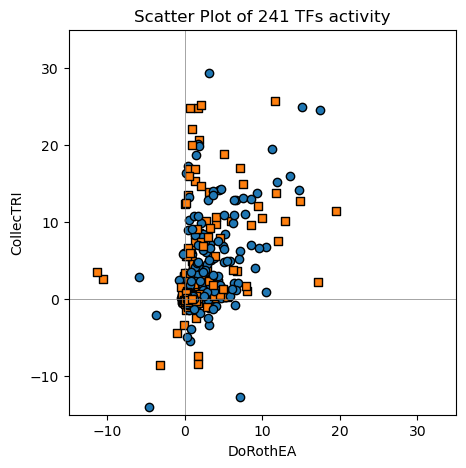

In [26]:
# Merge two dataframes based on the matched columns
df_merged_mean = pd.merge(df_tgfb_collectri_acts_overlap_mean, df_tgfb_dorothea_acts_overlap_mean, left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

# Create a scatter plot
plt.figure(figsize=(5,5))  # Adjust the figure size

color2 = sns.color_palette(None, 2)

for i, col in enumerate(df_tgfb_collectri_acts_overlap_mean.columns):
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_mean.iloc[[0]],
                    color=color2[0],
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_mean.iloc[[1]],
                    color=color2[1],
                    marker='s',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=color2[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(df_merged_mean.index.to_list())]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1)).remove()
plt.xlim([-15, 35])
plt.ylim([-15, 35])
plt.xlabel('DoRothEA')
plt.ylabel('CollecTRI')
plt.title(f'Scatter Plot of {len(df_tgfb_collectri_acts_overlap.columns)} TFs activity')
plt.show()

#### Plot Scatter between CollecTRI and DoRothEA - 7 TFs with DEA

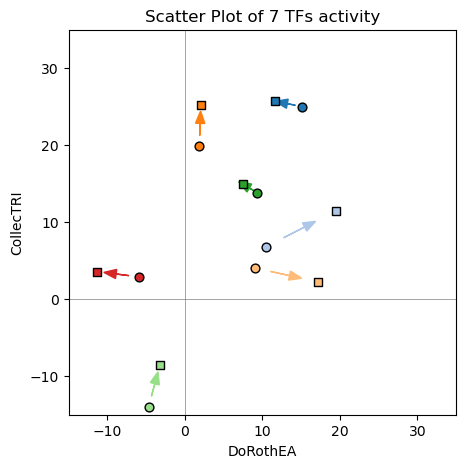

In [27]:
columns_to_select =  ['SMAD3','TBP','SMAD4','ETV4','EGR1','RFX5','RELA']

# Combine the 'tab20' and 'Set3' palettes
colors = sns.color_palette('tab20', 20) + sns.color_palette('Set3', 13)

# Merge two dataframes based on the matched columns
df_merged_tgfb = pd.merge(df_tgfb_collectri_acts_overlap_mean[columns_to_select], df_tgfb_dorothea_acts_overlap_mean[columns_to_select], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))
df_merged_dea = pd.merge(df_dea_collectri_acts_overlap[columns_to_select], df_dea_dorothea_acts_overlap[columns_to_select], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))
df_merged_mean = pd.concat([df_merged_tgfb,df_merged_dea.rename(index={"treatment.vs.control":2})], axis=0).rename(index={0:"control",1:"treatment",2:"dea"})

# Function to calculate dynamic offset, scaled by relative magnitude
def calculate_offset(start, end, max_change, scale_factor=0.3):
    change = end - start
    relative_change = abs(change) / max_change
    offset = relative_change * scale_factor * max_change
    return offset if change > 0 else -offset

# Calculate the maximum change for scaling offsets
max_x_change = abs(df_merged_mean.iloc[1] - df_merged_mean.iloc[0]).max()
max_y_change = abs(df_merged_mean.iloc[1] - df_merged_mean.iloc[0]).max()

# Create a scatter plot
plt.figure(figsize=(5,5))  # Adjust the figure size

color2 = sns.color_palette(None, 2)
for i, col in enumerate(columns_to_select):

    # Calculate start and end points for arrows with scaled offset
    start_x = df_merged_mean.iloc[0][f"{col}_dorothea"] + calculate_offset(df_merged_mean.iloc[0][f"{col}_dorothea"], df_merged_mean.iloc[1][f"{col}_dorothea"], max_x_change, 0.25)
    start_y = df_merged_mean.iloc[0][f"{col}_collectri"] + calculate_offset(df_merged_mean.iloc[0][f"{col}_collectri"], df_merged_mean.iloc[1][f"{col}_collectri"], max_y_change, 0.25)
    end_x = df_merged_mean.iloc[1][f"{col}_dorothea"] + calculate_offset(df_merged_mean.iloc[1][f"{col}_dorothea"], df_merged_mean.iloc[0][f"{col}_dorothea"], max_x_change, 0.45)
    end_y = df_merged_mean.iloc[1][f"{col}_collectri"] + calculate_offset(df_merged_mean.iloc[1][f"{col}_collectri"], df_merged_mean.iloc[0][f"{col}_collectri"], max_y_change, 0.45)

    plt.arrow(start_x, start_y,
              end_x - start_x,
              end_y - start_y,
              head_width=1.2, head_length=1.6, fc=colors[i], ec=colors[i])
    
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_mean.iloc[[0]],
                    color=colors[i],
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    s=40)
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_mean.iloc[[1]],
                    color=colors[i],
                    marker='s',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    s=40)


# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=colors,
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(df_merged_mean.index.to_list())]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1)).remove()
plt.xlim([-15, 35])
plt.ylim([-15, 35])
plt.xticks([-10, 0, 10, 20, 30])
plt.yticks([-10, 0, 10, 20, 30])
plt.xlabel('DoRothEA')
plt.ylabel('CollecTRI')
plt.title(f'Scatter Plot of {len(columns_to_select)} TFs activity')
plt.show()

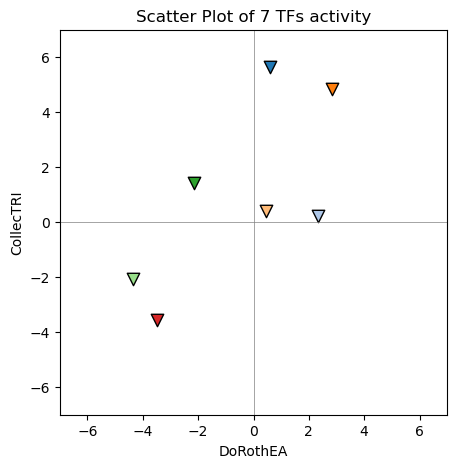

In [28]:
columns_to_select =  ['SMAD3','TBP','SMAD4','ETV4','EGR1','RFX5','RELA']

# Combine the 'tab20' and 'Set3' palettes
colors = sns.color_palette('tab20', 20) + sns.color_palette('Set3', 13)

# Merge two dataframes based on the matched columns
df_merged_tgfb = pd.merge(df_tgfb_collectri_acts_overlap_mean[columns_to_select], df_tgfb_dorothea_acts_overlap_mean[columns_to_select], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))
df_merged_dea = pd.merge(df_dea_collectri_acts_overlap[columns_to_select], df_dea_dorothea_acts_overlap[columns_to_select], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))
df_merged_mean = pd.concat([df_merged_tgfb,df_merged_dea.rename(index={"treatment.vs.control":2})], axis=0).rename(index={0:"control",1:"treatment",2:"dea"})

# Create a scatter plot
plt.figure(figsize=(5,5))  # Adjust the figure size

color2 = sns.color_palette(None, 2)
for i, col in enumerate(columns_to_select):
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_mean.iloc[[2]],
                    color=colors[i],
                    marker='v',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    s=80)

# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=colors,
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(df_merged_mean.index.to_list())]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1)).remove()
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.yticks([-6, -4, -2, 0, 2, 4, 6])
plt.xlabel('DoRothEA')
plt.ylabel('CollecTRI')
plt.title(f'Scatter Plot of {len(columns_to_select)} TFs activity')
plt.show()

#### Plot Scatter between CollecTRI and DoRothEA - 241 TFs (similarity labeling)

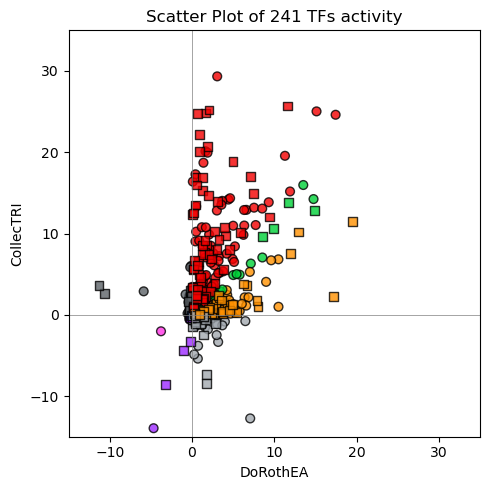

Control class counts:
control
1     20
2    102
3     59
4      1
5      4
6      3
7     19
8     33
Name: count, dtype: int64

Treatment class counts:
treatment
1    11
2    99
3    53
4     1
5    10
6     3
7    25
8    39
Name: count, dtype: int64


In [29]:
# Define the color map
cmap = ListedColormap(["#00d138", "#f30000", "#ff9100", "#005dff", "#9d2bff", "#ff35e5", "#5d6368", "#a3a9b0"])

# Create scatter plot
plt.figure(figsize=(5,5))

# Plot control points (first row in the dataframe)
plt.scatter(df_tgfb_dorothea_acts_overlap_mean.iloc[0], df_tgfb_collectri_acts_overlap_mean.iloc[0],
            c=df_tgfb_classes.iloc[0], cmap=cmap, alpha=0.8, edgecolors="k", linewidth=1, marker='o', s=40)

# Plot treatment points (second row in the dataframe)
plt.scatter(df_tgfb_dorothea_acts_overlap_mean.iloc[1], df_tgfb_collectri_acts_overlap_mean.iloc[1],
            c=df_tgfb_classes.iloc[1], cmap=cmap, alpha=0.8, edgecolors="k", linewidth=1, marker='s', s=40)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlim([-15, 35])
plt.ylim([-15, 35])
plt.xlabel('DoRothEA')
plt.ylabel('CollecTRI')
plt.title(f'Scatter Plot of {len(df_tgfb_collectri_acts_overlap_mean.columns)} TFs activity')
plt.tight_layout()
plt.show()

# Count the number of members in each class for control
control_class_counts = df_tgfb_classes.iloc[0].value_counts()
control_class_counts = control_class_counts.reindex(range(1, 9), fill_value=0)  # Ensure all classes are represented

# Count the number of members in each class for treatment
treatment_class_counts = df_tgfb_classes.iloc[1].value_counts()
treatment_class_counts = treatment_class_counts.reindex(range(1, 9), fill_value=0)  # Ensure all classes are represented

print("Control class counts:")
print(control_class_counts)
print("\nTreatment class counts:")
print(treatment_class_counts)

#### Plot Scatter between CollecTRI and DoRothEA - 241 TFs (similarity labeling)

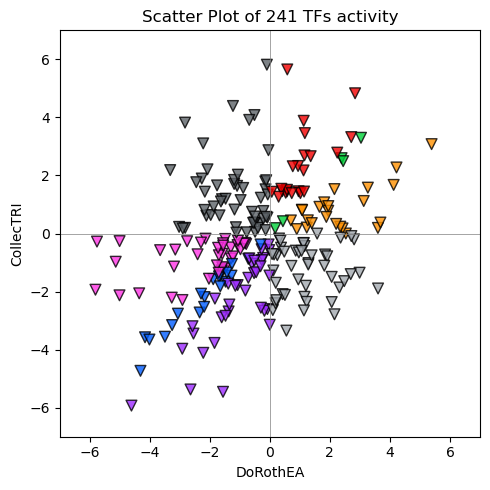

DEA class counts:
treatment.vs.control
1     5
2    22
3    25
4    21
5    34
6    37
7    52
8    45
Name: count, dtype: int64


In [30]:
columns_to_select =  ['SMAD3','TBP','SMAD4','ETV4','EGR1','RFX5','RELA']

# Define the color map
cmap = ListedColormap(["#00d138", "#f30000", "#ff9100", "#005dff", "#9d2bff", "#ff35e5", "#5d6368", "#a3a9b0"])

# Create scatter plot
plt.figure(figsize=(5,5))

# Plot control points (first row in the dataframe)
plt.scatter(df_dea_dorothea_acts_overlap, df_dea_collectri_acts_overlap,
            c=df_dea_classes.iloc[0], cmap=cmap, alpha=0.8, edgecolors="k", linewidth=1, marker='v', s=60)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.yticks([-6, -4, -2, 0, 2, 4, 6])
plt.xlabel('DoRothEA')
plt.ylabel('CollecTRI')
plt.title(f'Scatter Plot of {len(df_dea_dorothea_acts_overlap.columns)} TFs activity')
plt.tight_layout()
plt.show()

# Count the number of members in each class for control
dea_class_counts = df_dea_classes.iloc[0].value_counts()
dea_class_counts = dea_class_counts.reindex(range(1, 9), fill_value=0)  # Ensure all classes are represented

print("DEA class counts:")
print(dea_class_counts)

### **PART 2** PANACEA dataset - ALL TFs

#### Plot Venn diagram

all_collectri: 466
all_dorothea: 268

acts_collectri: 256
acts_dorothea: 58
acts_both: 210
acts_none: 0
acts_sum: 524


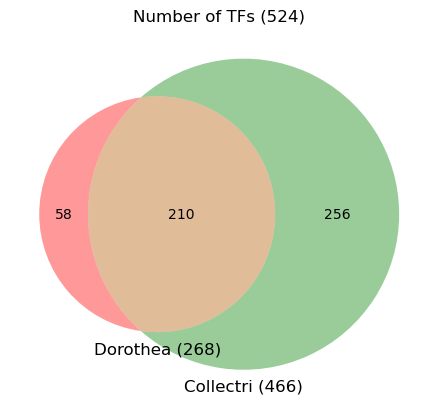

In [31]:
significant_tf_collectri = df_collectri_pvals.columns #[(df_collectri_pvals < 0.05).all()]
significant_tf_dorothea = df_dorothea_pvals.columns   #[(df_dorothea_pvals < 0.05).all()]

# Find the overlapping TFs between collectri and dorothea
overlap_tfs = set(df_collectri_acts.columns) & set(df_dorothea_acts.columns)

# Classify into 4 groups
# acts_collectri = overlap_tfs & set(significant_tf_collectri) - set(significant_tf_dorothea)
# acts_dorothea = overlap_tfs & set(significant_tf_dorothea) - set(significant_tf_collectri)
acts_collectri = set(significant_tf_collectri) - set(overlap_tfs)
acts_dorothea = set(significant_tf_dorothea) - set(overlap_tfs)
acts_both = overlap_tfs & set(significant_tf_collectri) & set(significant_tf_dorothea)
acts_none = overlap_tfs - acts_collectri - acts_dorothea - acts_both

# Convert set objects to lists
acts_collectri = list(acts_collectri)
acts_dorothea = list(acts_dorothea)
acts_both = list(acts_both)
acts_none = list(acts_none)

# Print the result
print(f"all_collectri: {len(df_collectri_pvals.columns):d}")
print(f"all_dorothea: {len(df_dorothea_pvals.columns):d}")
print("")
print(f"acts_collectri: {len(acts_collectri):d}")
print(f"acts_dorothea: {len(acts_dorothea):d}")
print(f"acts_both: {len(acts_both):d}")
print(f"acts_none: {len(acts_none):d}")
print(f"acts_sum: {len(acts_collectri)+len(acts_dorothea)+len(acts_both)+len(acts_none):d}")

# Plot Venn Diagram
venn = venn3(subsets={
    '100': len(acts_dorothea),  # Only Dorothea
    '010': len(acts_collectri),  # Only Collectri
    '110': len(acts_both),  # Significant in both
    # '001': len(acts_none)  # Not significant in either
}, set_labels=(f'Dorothea ({len(significant_tf_dorothea):d})', f'Collectri ({len(significant_tf_collectri):d})')) #, f'None ({len(acts_none):d})'
plt.title(f'Number of TFs ({len(acts_collectri)+len(acts_dorothea)+len(acts_both)+len(acts_none):d})')
plt.show()

#### Plot bar graph and boxplot

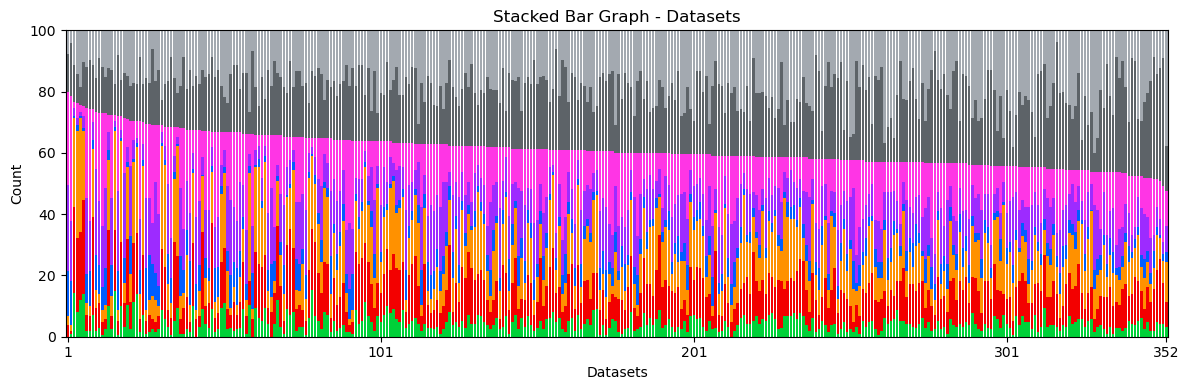

In [32]:
# Plot Summarize TF count by Datasets
# Given color map
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]

# Normalize the data by dividing by the sum across the row
df_normalized = df_classes_datasets_sorted.div(df_classes_datasets_sorted.sum(axis=1), axis=0) * 100

# Plotting the stacked bar graph
ax = df_normalized.plot(kind='bar', stacked=True, figsize=(12, 4), width=0.8, color=cmap, legend=False)

# Calculate the positions for x-ticks every 20 units
tick_positions = range(0, len(df_normalized), 100)

# Add the last position if it's not already included
if len(df_normalized) - 1 not in tick_positions:
    tick_positions = list(tick_positions) + [len(df_normalized) - 1]

# Set x-ticks and x-tick labels
ax.set_xticks(tick_positions)
# ax.set_xticklabels([df_classes_datasets_sorted.index[i] for i in tick_positions], rotation=0, ha='center')
ax.set_xticklabels([i+1 for i in tick_positions], rotation=0, ha='center')

# Setting some additional attributes to make the graph more readable
ax.set_title("Stacked Bar Graph - Datasets")
ax.set_ylabel("Count")
ax.set_xlabel("Datasets")
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

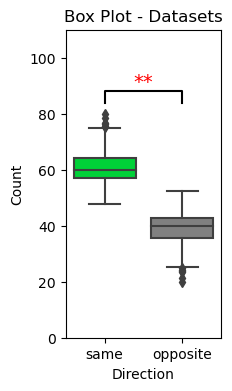

In [33]:
# Normalize the data by dividing by the sum across the row
df_normalized = df_classes_datasets.div(df_classes_datasets.sum(axis=0), axis=1) * 100

# Calculate m1 and m2
m1 = df_normalized.loc[1] + df_normalized.loc[2] + df_normalized.loc[3] + df_normalized.loc[4] + df_normalized.loc[5] + df_normalized.loc[6]
m2 = df_normalized.loc[7] + df_normalized.loc[8]

# Perform the Mann-Whitney U test
stat, p_value = stats.mannwhitneyu(m1, m2)

# Create a new DataFrame for plotting
df_plot = pd.DataFrame({
    'Direction': ['m1'] * len(m1) + ['m2'] * len(m2),
    'Count': pd.concat([m1, m2], ignore_index=True)
})

# Create the box plot
plt.figure(figsize=(2,4))
ax = sns.boxplot(x='Direction', y='Count', data=df_plot)

# Define custom colors for each box
box_colors = ["#00d138", "#808080"]  # First color for m1, second color for m2

# Set the colors of each box
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(box_colors[i])

# Calculate the maximum value for the y-axis limit
max_y_value = max(max(m1), max(m2))

# Extend the y-axis limit for the asterisk
ax.set_ylim(0, max_y_value * 1.2)  # Extends the limit by 10%

# Annotate plot with the significance level
if p_value < 0.05:
    y, h, col = max_y_value * 1.05, max_y_value * 0.05, 'k'
    ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
    if p_value < 0.01:
        ax.text(0.5, y+h, '**', ha='center', va='bottom', color='red', fontsize=14)
    else:
        ax.text(0.5, y+h, '*', ha='center', va='bottom', color='red', fontsize=14)

plt.title('Box Plot - Datasets')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.ylim([0,110])
plt.yticks([0,20,40,60,80,100])
plt.xticks(ticks=[0, 1], labels=["same", "opposite"])
plt.show()

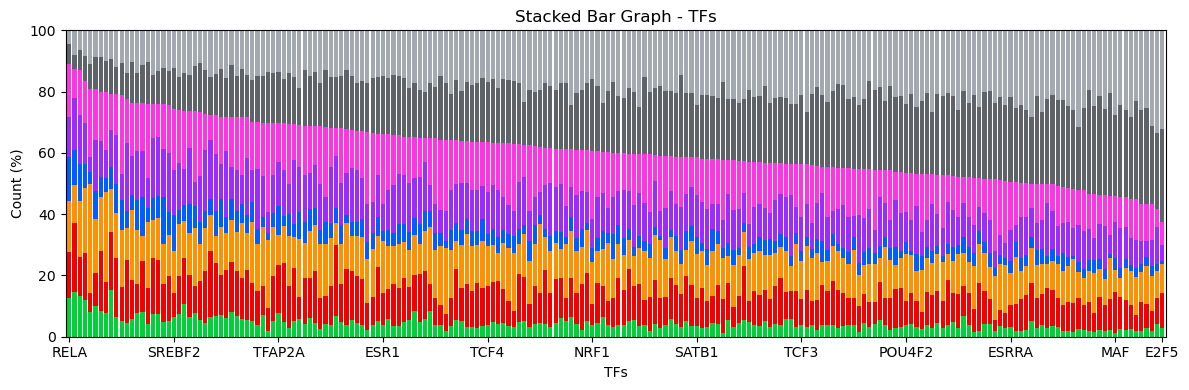

In [34]:
# Plot Summarize TF count by TFs
# Given color map
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]

# Normalize the data by dividing by the sum across the row
df_normalized = df_classes_tfs_sorted.div(df_classes_tfs_sorted.sum(axis=1), axis=0) * 100

# Plotting the stacked bar graph
ax = df_normalized.plot(kind='bar', stacked=True, figsize=(12, 4), width=0.8, color=cmap, legend=False)

# Calculate the positions for x-ticks every 20 units
tick_positions = range(0, len(df_normalized), 20)

# Add the last position if it's not already included
if len(df_normalized) - 1 not in tick_positions:
    tick_positions = list(tick_positions) + [len(df_normalized) - 1]

# Set x-ticks and x-tick labels
ax.set_xticks(tick_positions)
ax.set_xticklabels([df_normalized.index[i] for i in tick_positions], rotation=0, ha='center')

# Setting some additional attributes to make the graph more readable
ax.set_title("Stacked Bar Graph - TFs")
ax.set_ylabel("Count (%)")
ax.set_xlabel("TFs")
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

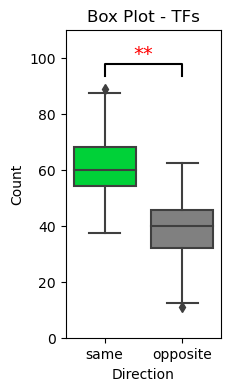

In [35]:
# Normalize the data by dividing by the sum across the row
df_normalized = df_classes_tfs.div(df_classes_tfs.sum(axis=0), axis=1) * 100

# Calculate m1 and m2
m1 = df_normalized.loc[1] + df_normalized.loc[2] + df_normalized.loc[3] + df_normalized.loc[4] + df_normalized.loc[5] + df_normalized.loc[6]
m2 = df_normalized.loc[7] + df_normalized.loc[8]

# Create a new DataFrame for plotting
df_plot = pd.DataFrame({
    'Direction': ['m1'] * len(m1) + ['m2'] * len(m2),
    'Count': pd.concat([m1, m2], ignore_index=True)
})

# Create the box plot
plt.figure(figsize=(2,4))
ax = sns.boxplot(x='Direction', y='Count', data=df_plot)

# Define custom colors for each box
box_colors = ["#00d138", "#808080"]  # First color for m1, second color for m2

# Set the colors of each box
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(box_colors[i])

# Calculate the maximum value for the y-axis limit
max_y_value = max(max(m1), max(m2))

# Extend the y-axis limit for the asterisk
ax.set_ylim(0, max_y_value * 1.2)  # Extends the limit by 10%

# Annotate plot with the significance level
if p_value < 0.05:
    y, h, col = max_y_value * 1.05, max_y_value * 0.05, 'k'
    ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
    if p_value < 0.01:
        ax.text(0.5, y+h, '**', ha='center', va='bottom', color='red', fontsize=14)
    else:
        ax.text(0.5, y+h, '*', ha='center', va='bottom', color='red', fontsize=14)

plt.title('Box Plot - TFs')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.ylim([0,110])
plt.yticks([0,20,40,60,80,100])
plt.xticks(ticks=[0, 1], labels=["same", "opposite"])
plt.show()

#### Plot Jaccard Index, Size, Weight on TFs

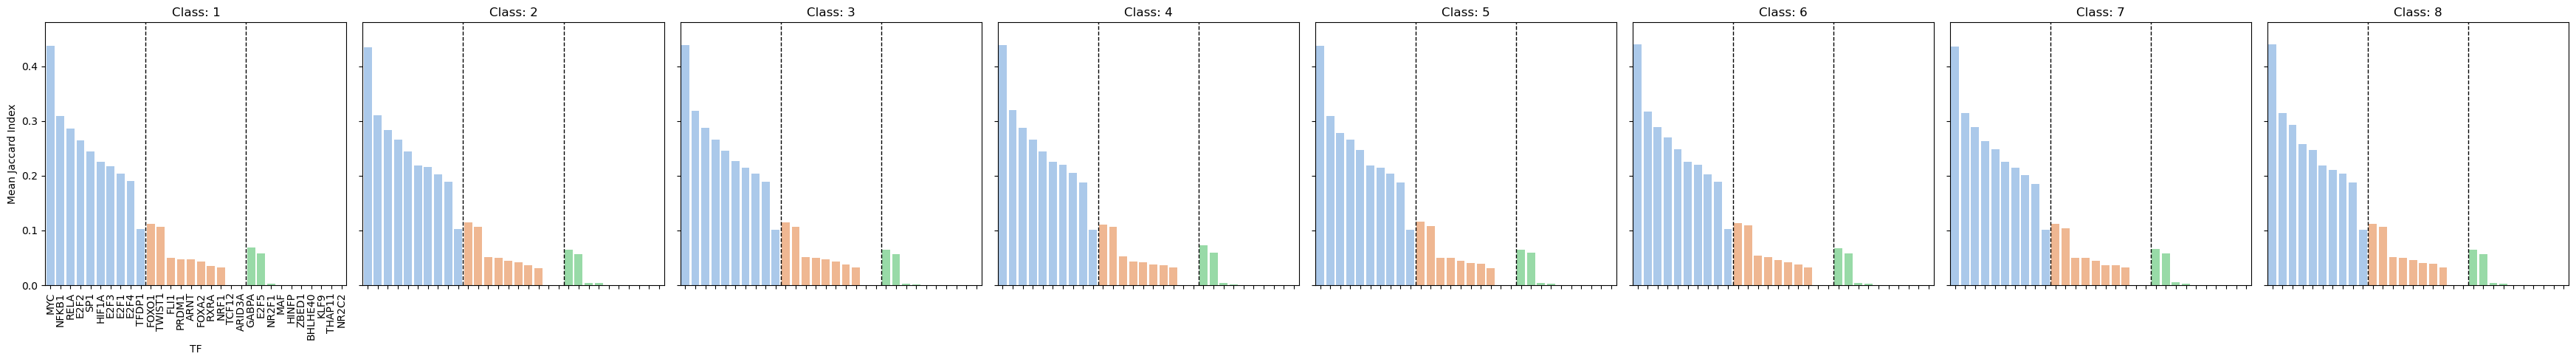

In [36]:
# Number of unique classes
num_classes = df_results_sorted['class'].nunique()

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35,5))

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_results_sorted.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_jaccard', hue='tf_group', ax=ax, dodge=False, palette="pastel")
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 0.48])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Jaccard Index')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks

    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()

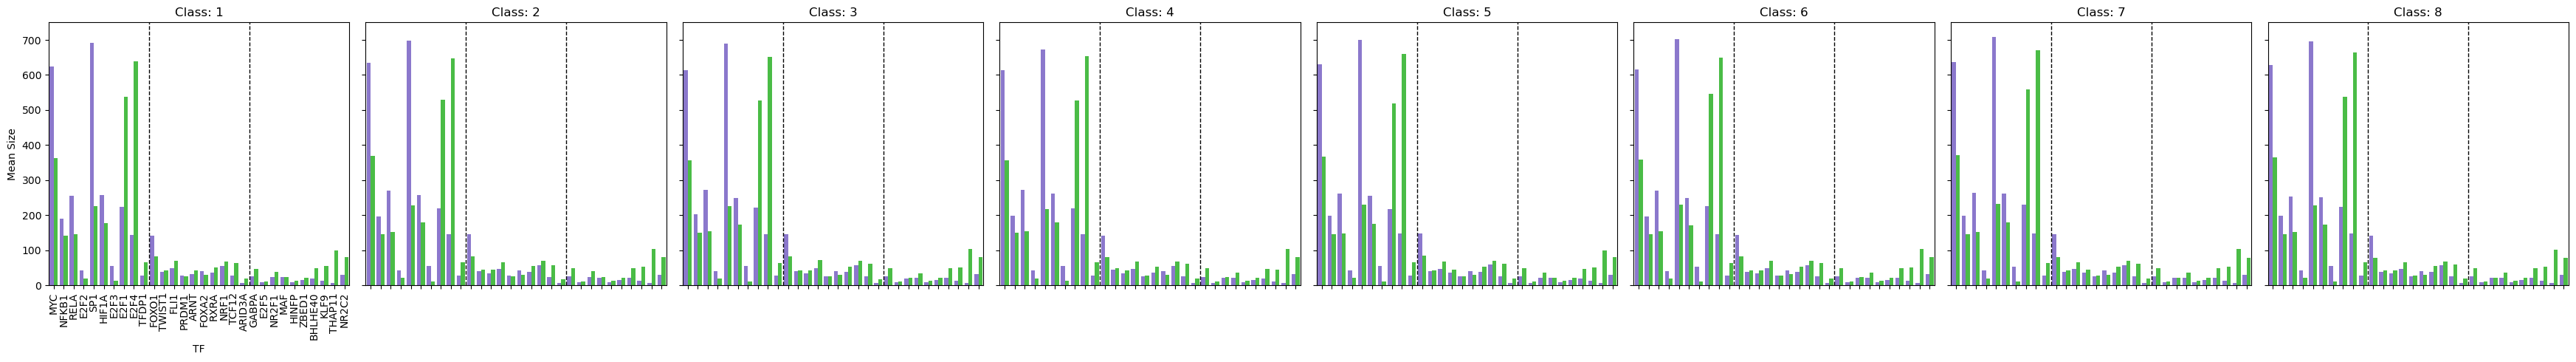

In [37]:
# Melt df_results_sorted for the sizes
df_melted_size = pd.melt(df_results_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['size_collectri_mean', 'size_dorothea_mean'], 
                    var_name='dataset', value_name='median_size')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_size.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='median_size', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 750])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Size')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()

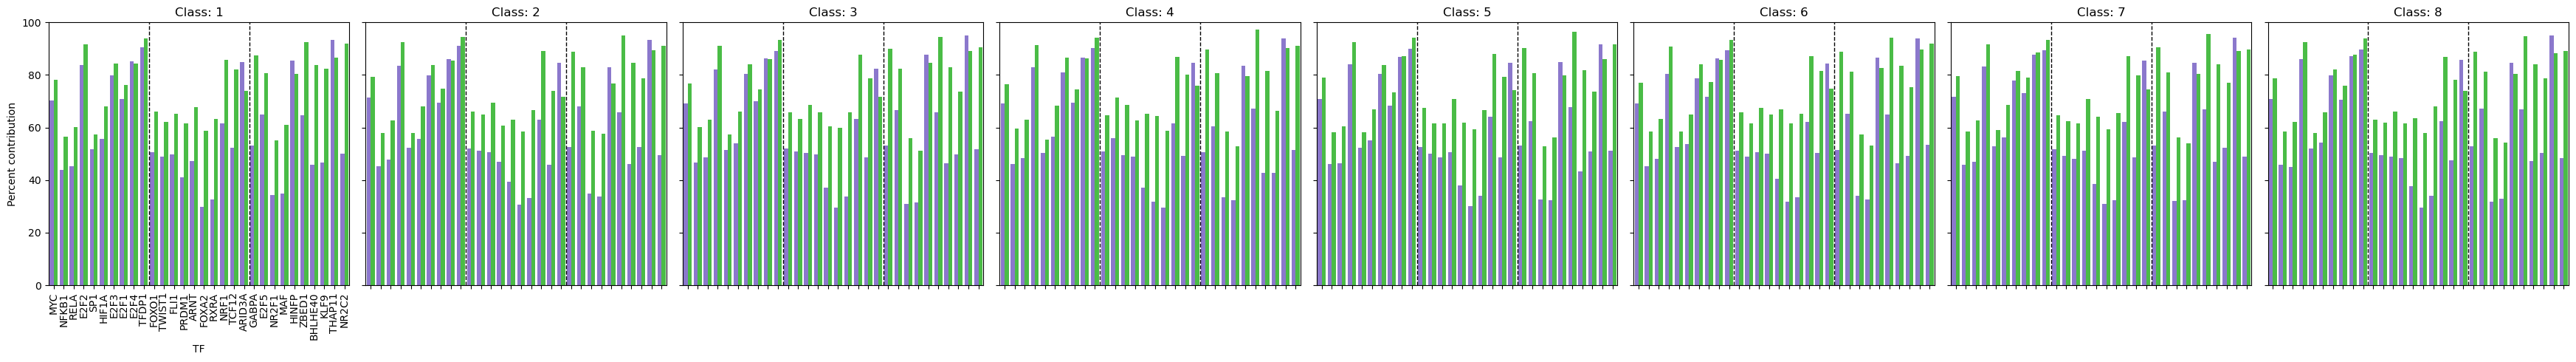

In [38]:
# Melt df_results_sorted for the sizes
df_melted_contribute = pd.melt(df_results_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['contribute_collectri_mean', 'contribute_dorothea_mean'], 
                    var_name='dataset', value_name='mean_contribute')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_contribute.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_contribute', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 100])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Percent contribution')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()

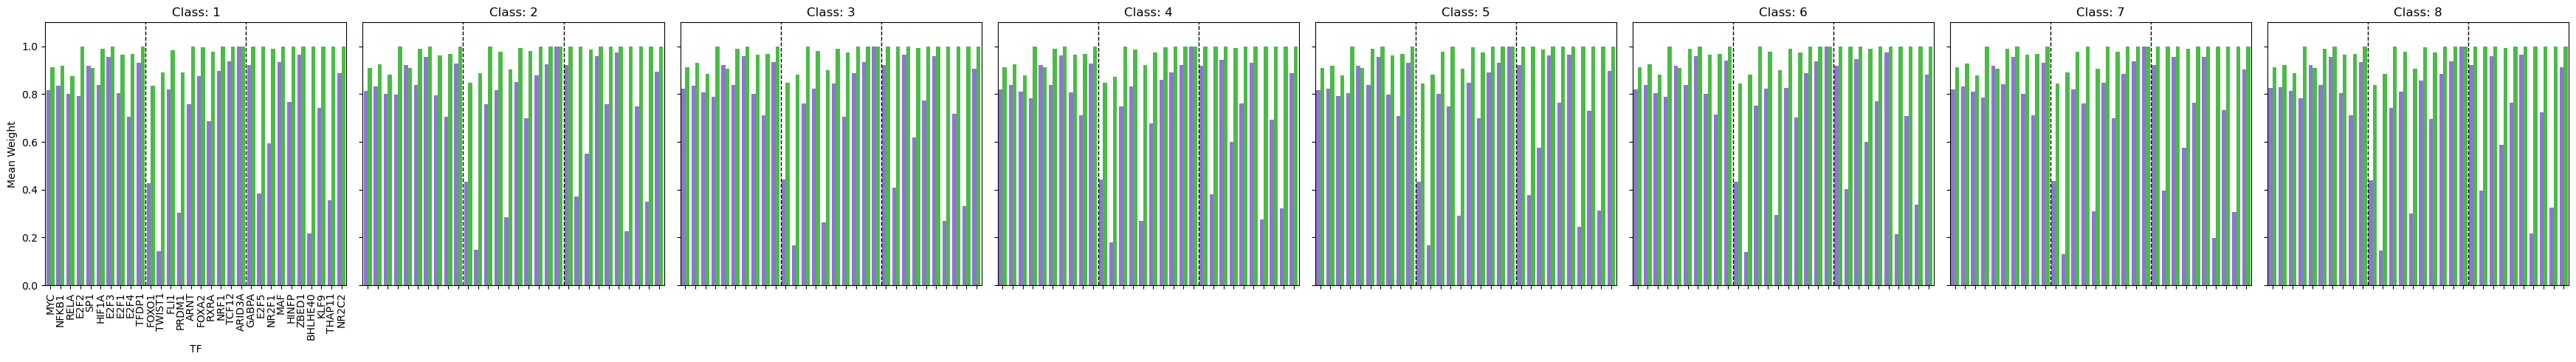

In [39]:
# Melt df_results_sorted for the sizes
df_melted_weight = pd.melt(df_results_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['weight_collectri_mean', 'weight_dorothea_mean'], 
                    var_name='dataset', value_name='mean_weight')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_weight.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_weight', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 1.1])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Weight')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()

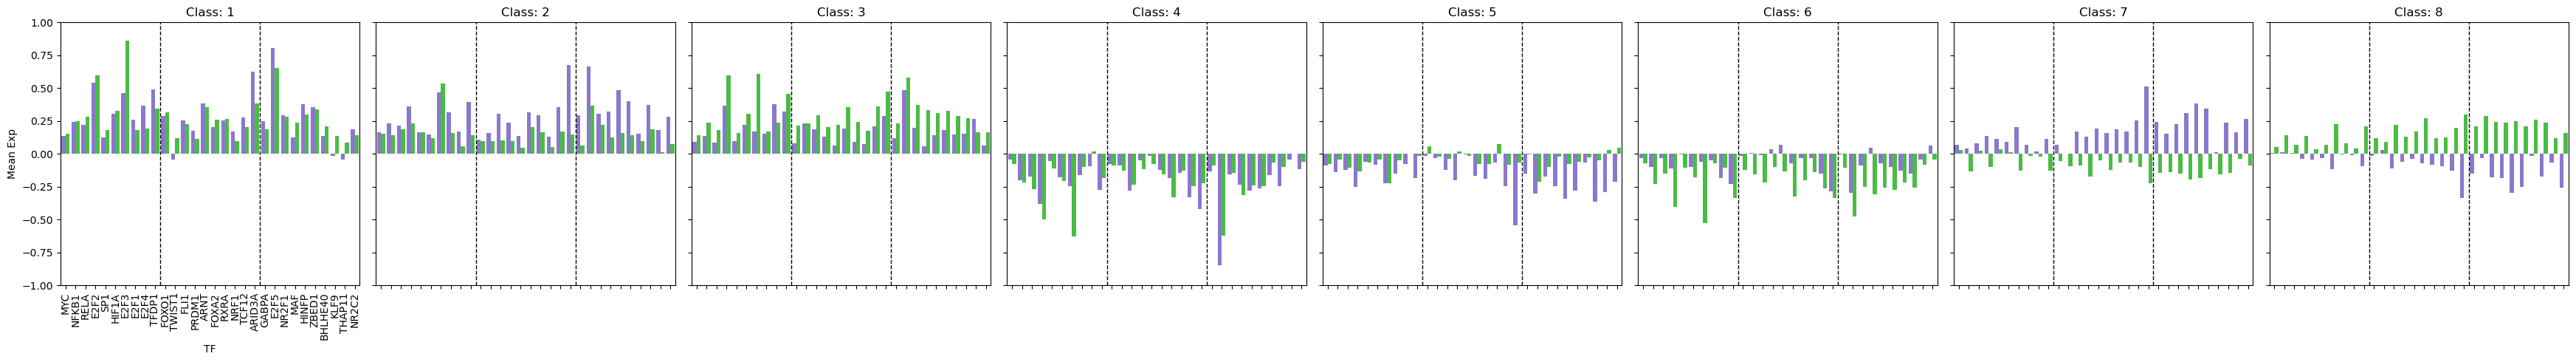

In [40]:
# Melt df_results_sorted for the sizes
df_melted_mean = pd.melt(df_results_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['mean_collectri_mean', 'mean_dorothea_mean'], 
                    var_name='dataset', value_name='mean_expression')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_mean.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_expression', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([-1, 1])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Exp')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()


#### Plot Jaccard, regulons, weight - aggregate boxplot

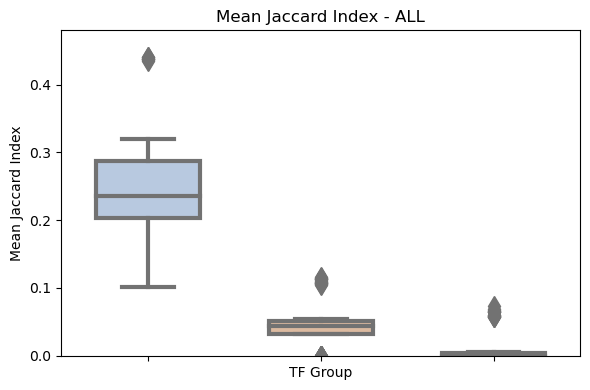

In [41]:
# Define the custom color palette
custom_palette = ["#B1C8E7", "#E6B996", "#A5D7AA"]

# Create a single boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

# Plotting the boxplot
sns.boxplot(data=df_results_sorted, x='tf_group', y='mean_jaccard', 
            palette=custom_palette, width=0.6, fliersize=10, linewidth=3)

plt.title('Mean Jaccard Index - ALL')
plt.ylabel('Mean Jaccard Index')
plt.xlabel('TF Group')
plt.ylim([0, 0.48])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.show()


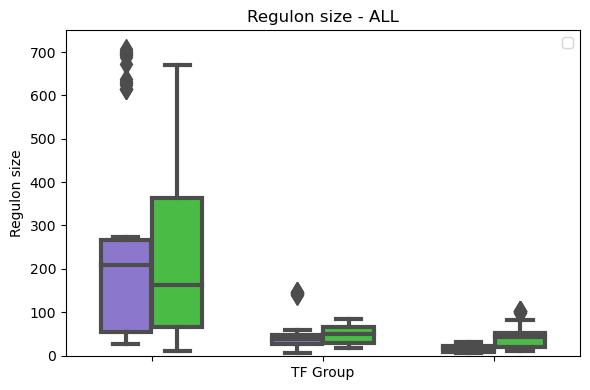

In [42]:
# Reshape the DataFrame to long format
df_long = df_results_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['size_collectri_mean', 'size_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)

plt.title('Regulon size - ALL')
plt.ylabel('Regulon size')
plt.xlabel('TF Group')
plt.ylim([0, 750])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()


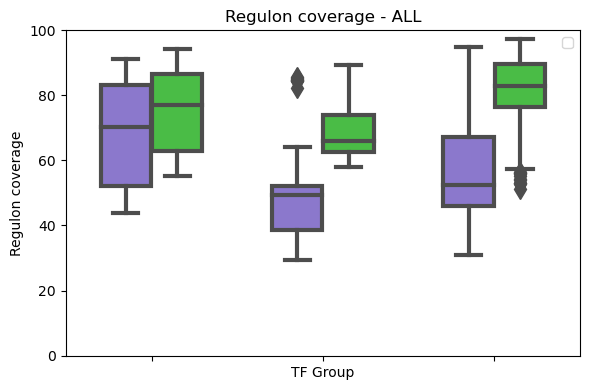

In [43]:
# Reshape the DataFrame to long format
df_long = df_results_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['contribute_collectri_mean', 'contribute_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)

plt.title('Regulon coverage - ALL')
plt.ylabel('Regulon coverage')
plt.xlabel('TF Group')
plt.ylim([0, 100])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()


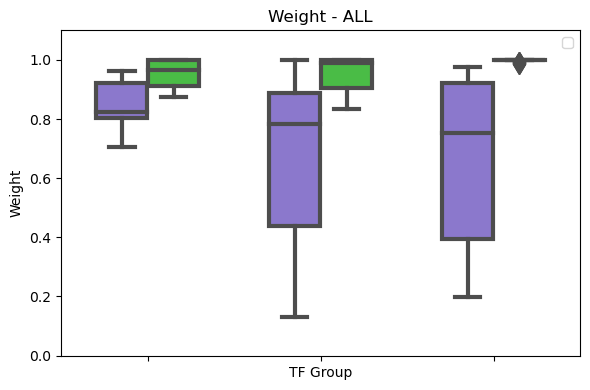

In [44]:
# Reshape the DataFrame to long format
df_long = df_results_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['weight_collectri_mean', 'weight_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)

plt.title('Weight - ALL')
plt.ylabel('Weight')
plt.xlabel('TF Group')
plt.ylim([0, 1.1])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()


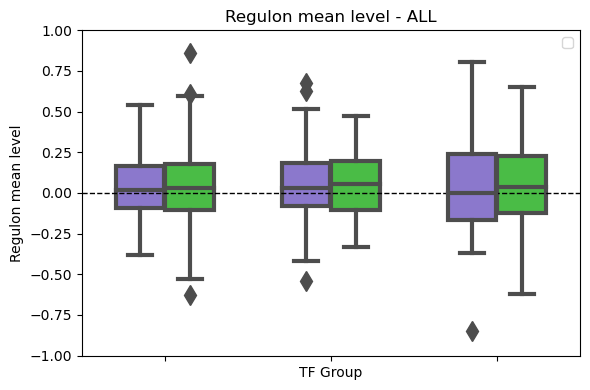

In [45]:
# Reshape the DataFrame to long format
df_long = df_results_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['mean_collectri_mean', 'mean_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Regulon mean level - ALL')
plt.ylabel('Regulon mean level')
plt.xlabel('TF Group')
plt.ylim([-1, 1])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()


### **PART 3** PANACEA dataset - SIGNIFICANT TFs

#### Plot Scatter TFs - all population

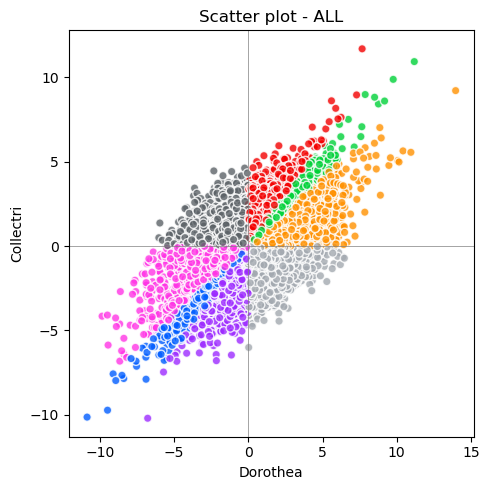

In [48]:
x_values = df_dorothea_acts_overlap.values.flatten()
y_values = df_collectri_acts_overlap.values.flatten()
colors = df_classes.values.flatten()

# Define the color map
cmap = ListedColormap(["#00d138", "#f30000", "#ff9100", "#005dff", "#9d2bff", "#ff35e5", "#5d6368", "#a3a9b0"])

# Create scatter plot
plt.figure(figsize=(5, 5))
scatter = plt.scatter(x_values, y_values, c=colors, cmap=cmap, alpha=0.8, edgecolors="w", linewidth=1)

plt.xlabel('Dorothea')
plt.ylabel('Collectri')
plt.title('Scatter plot - ALL')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()


#### Plot Scatter TFs - significant

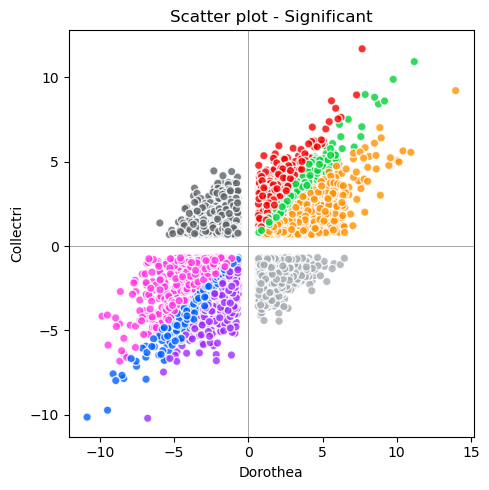

In [49]:
mask = df_classes_sig == 3
x_values = df_dorothea_acts_overlap[mask].values.flatten()
y_values = df_collectri_acts_overlap[mask].values.flatten()
colors = df_classes[mask].values.flatten()

# Define the color map
# cmap = ListedColormap(["#B7B7B7","#9570FF", "#00C537", "#E56310"])  # Colors for classes 1, 2, 3
# cmap = ListedColormap(["#EBC800"])  # Colors for classes 3
cmap = ListedColormap(["#00d138", "#f30000", "#ff9100", "#005dff", "#9d2bff", "#ff35e5", "#5d6368", "#a3a9b0"])

# Create scatter plot
plt.figure(figsize=(5, 5))
scatter = plt.scatter(x_values, y_values, c=colors, cmap=cmap, alpha=0.8, edgecolors="w", linewidth=1)

plt.xlabel('Dorothea')
plt.ylabel('Collectri')
plt.title('Scatter plot - Significant')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()


#### Plot bar graph and boxplot - significant

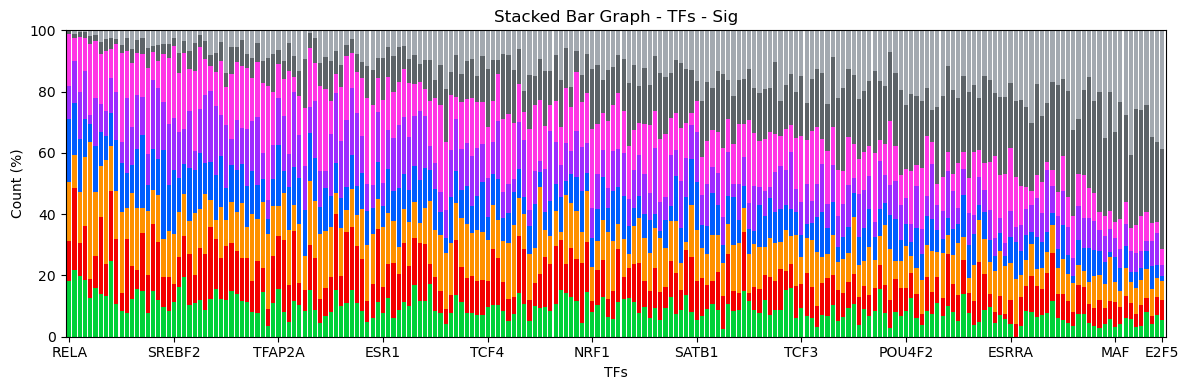

In [50]:
# Plot Summarize TF count by TFs
# Given color map
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]

# Normalize the data by dividing by the sum across the row
df_normalized = df_both_pvals_classes_tfs_sorted.div(df_both_pvals_classes_tfs_sorted.sum(axis=1), axis=0) * 100

# Plotting the stacked bar graph
ax = df_normalized.plot(kind='bar', stacked=True, figsize=(12, 4), width=0.8, color=cmap, legend=False)

# Calculate the positions for x-ticks every 20 units
tick_positions = range(0, len(df_normalized), 20)

# Add the last position if it's not already included
if len(df_normalized) - 1 not in tick_positions:
    tick_positions = list(tick_positions) + [len(df_normalized) - 1]

# Set x-ticks and x-tick labels
ax.set_xticks(tick_positions)
ax.set_xticklabels([df_normalized.index[i] for i in tick_positions], rotation=0, ha='center')

# Setting some additional attributes to make the graph more readable
ax.set_title("Stacked Bar Graph - TFs - Sig")
ax.set_ylabel("Count (%)")
ax.set_xlabel("TFs")
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

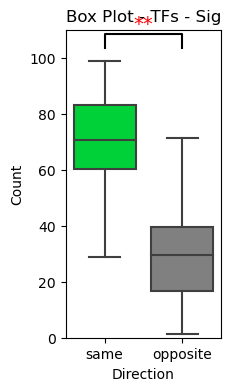

In [51]:
# Normalize the data by dividing by the sum across the row
df_normalized = df_both_pvals_classes_tfs.div(df_both_pvals_classes_tfs.sum(axis=0), axis=1) * 100

# Calculate m1 and m2
m1 = df_normalized.loc[1] + df_normalized.loc[2] + df_normalized.loc[3] + df_normalized.loc[4] + df_normalized.loc[5] + df_normalized.loc[6]
m2 = df_normalized.loc[7] + df_normalized.loc[8]

# Create a new DataFrame for plotting
df_plot = pd.DataFrame({
    'Direction': ['m1'] * len(m1) + ['m2'] * len(m2),
    'Count': pd.concat([m1, m2], ignore_index=True)
})

# Create the box plot
plt.figure(figsize=(2,4))
ax = sns.boxplot(x='Direction', y='Count', data=df_plot)

# Define custom colors for each box
box_colors = ["#00d138", "#808080"]  # First color for m1, second color for m2

# Set the colors of each box
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(box_colors[i])

# Calculate the maximum value for the y-axis limit
max_y_value = max(max(m1), max(m2))

# Extend the y-axis limit for the asterisk
ax.set_ylim(0, max_y_value * 1.2)  # Extends the limit by 10%

# Annotate plot with the significance level
if p_value < 0.05:
    y, h, col = max_y_value * 1.05, max_y_value * 0.05, 'k'
    ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
    if p_value < 0.01:
        ax.text(0.5, y+h, '**', ha='center', va='bottom', color='red', fontsize=14)
    else:
        ax.text(0.5, y+h, '*', ha='center', va='bottom', color='red', fontsize=14)

plt.title('Box Plot - TFs - Sig')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.ylim([0,110])
plt.yticks([0,20,40,60,80,100])
plt.xticks(ticks=[0, 1], labels=["same", "opposite"])
plt.show()

#### Plot percent change after remove non-significant

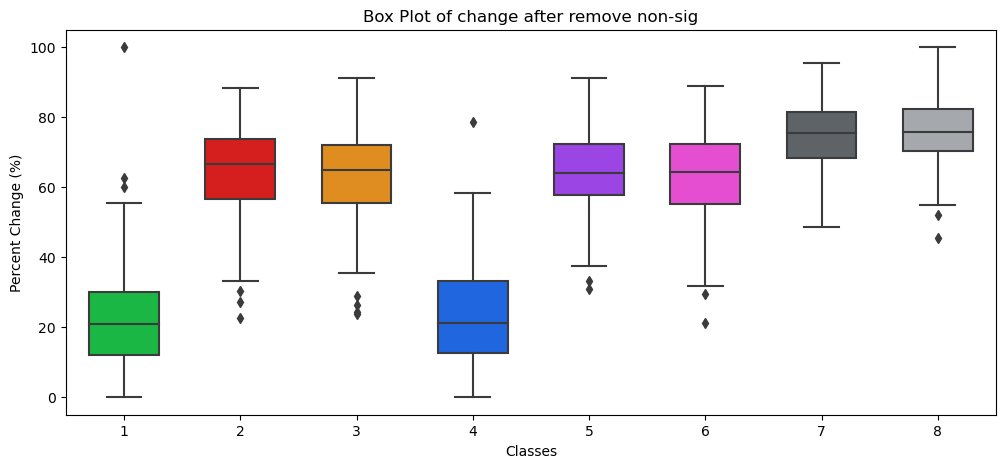

In [52]:
# Given color map
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]

# Calculate the percent change
percent_change = (df_classes_tfs_sorted - df_both_pvals_classes_tfs_sorted) / df_classes_tfs_sorted * 100

# Handle divisions by zero if any
percent_change = percent_change.fillna(0)

# Melt the DataFrame for box plotting
df_melted = percent_change.reset_index().melt(id_vars='index', var_name='Column', value_name='PercentChange')

# Create the box plot
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_melted, x='Column', y='PercentChange', width=0.6, palette=cmap)
plt.title('Box Plot of change after remove non-sig')
plt.xlabel('Classes')
plt.ylabel('Percent Change (%)')
plt.xticks(rotation=0)
plt.show()

#### Plot Jaccard Index, Size, Weight on TFs - significant

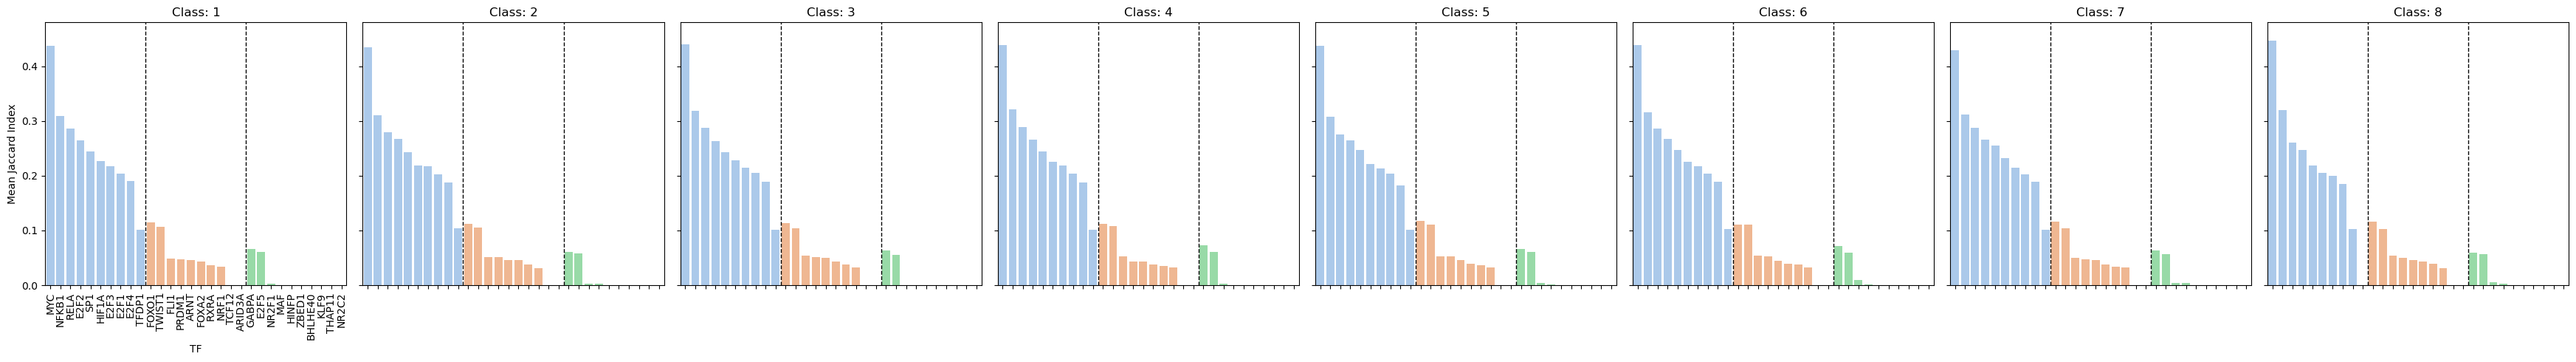

In [53]:
# Number of unique classes
num_classes = df_results_sig_sorted['class'].nunique()

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35,5))

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_results_sig_sorted.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_jaccard', hue='tf_group', ax=ax, dodge=False, palette="pastel")
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 0.48])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Jaccard Index')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks

    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')
plt.tight_layout()
plt.show()

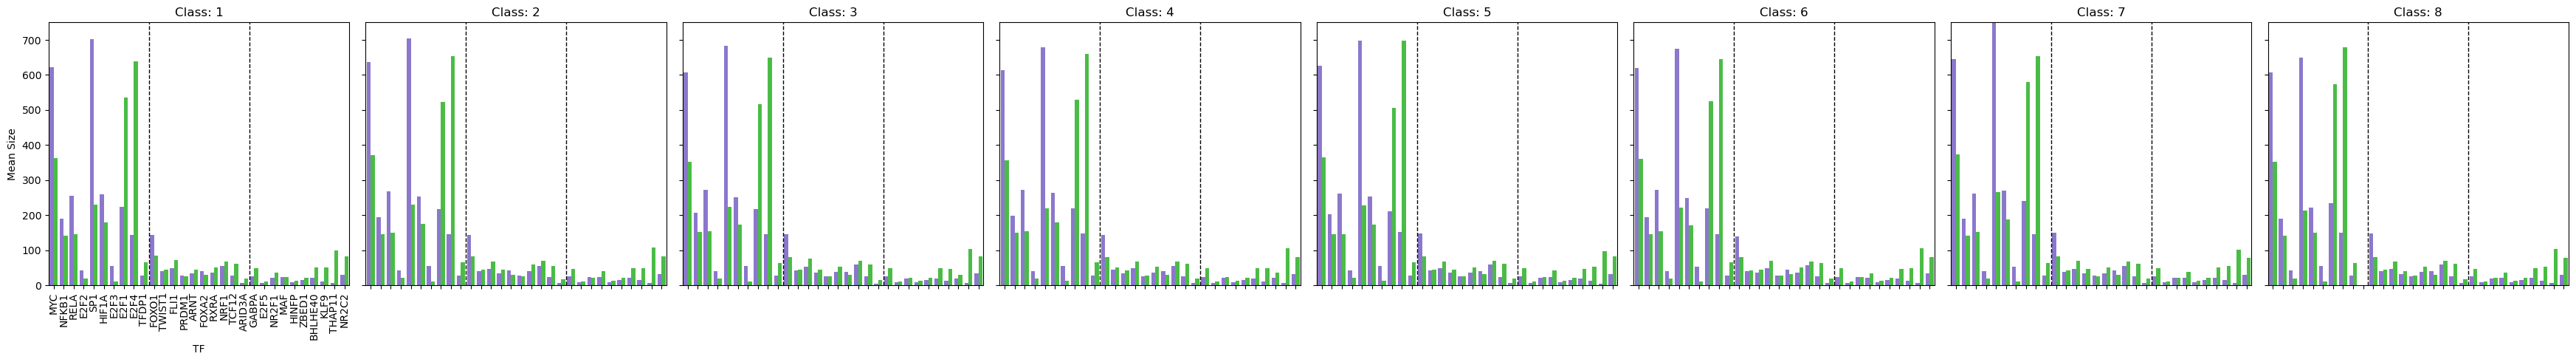

In [54]:
# Melt df_results_sorted for the sizes
df_melted_size = pd.melt(df_results_sig_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['size_collectri_mean', 'size_dorothea_mean'], 
                    var_name='dataset', value_name='median_size')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_size.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='median_size', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 750])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Size')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()

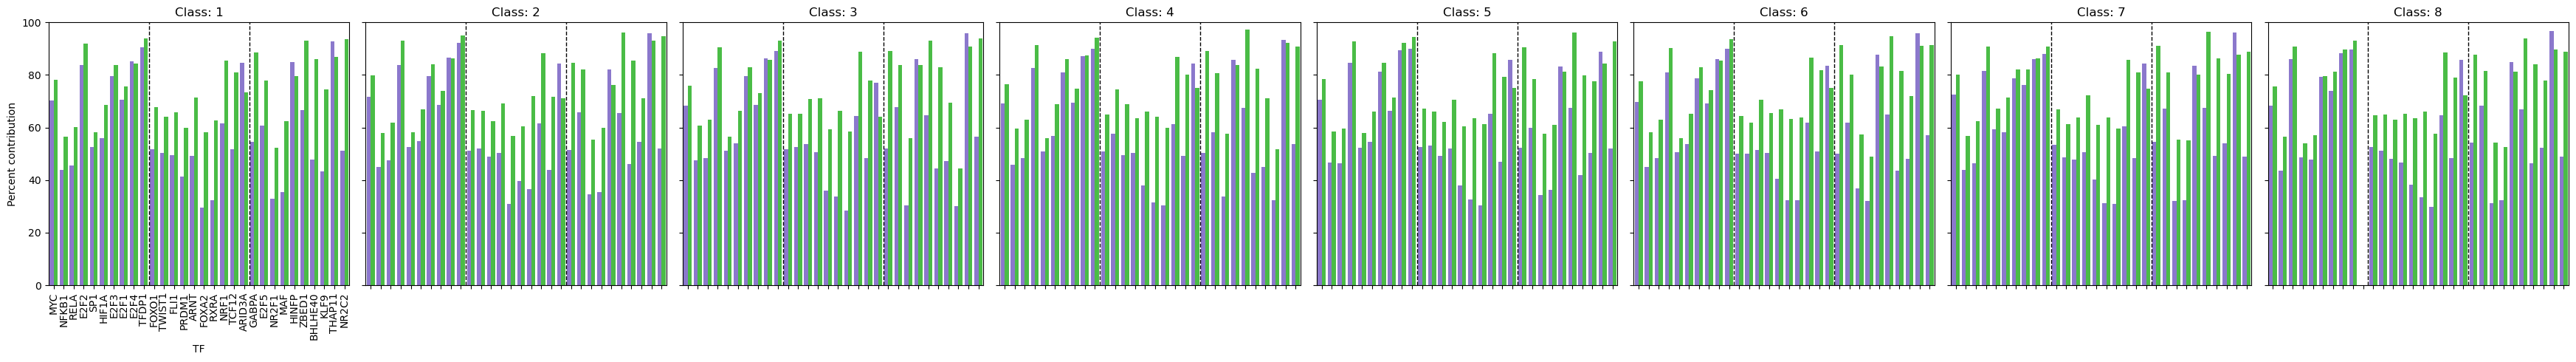

In [55]:
# Melt df_results_sorted for the sizes
df_melted_contribute = pd.melt(df_results_sig_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['contribute_collectri_mean', 'contribute_dorothea_mean'], 
                    var_name='dataset', value_name='mean_contribute')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_contribute.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_contribute', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 100])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Percent contribution')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()

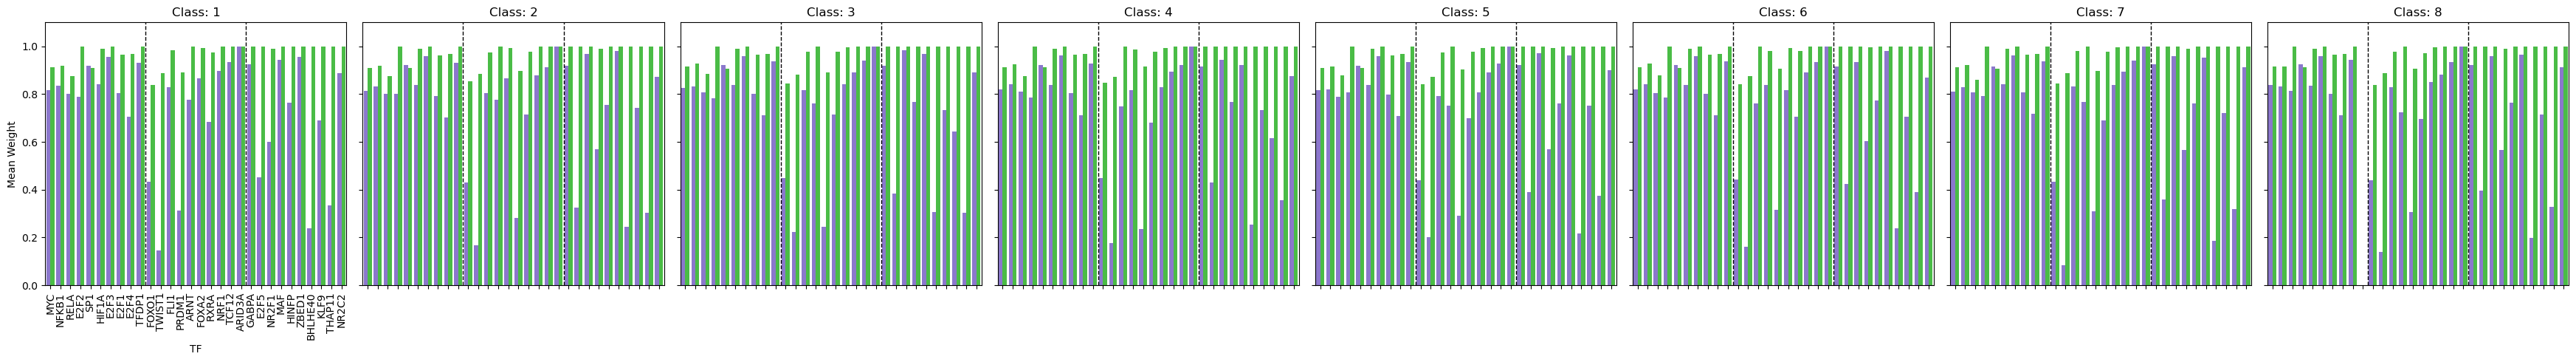

In [56]:
# Melt df_results_sorted for the sizes
df_melted_weight = pd.melt(df_results_sig_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['weight_collectri_mean', 'weight_dorothea_mean'], 
                    var_name='dataset', value_name='mean_weight')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_weight.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_weight', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([0, 1.1])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Weight')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()

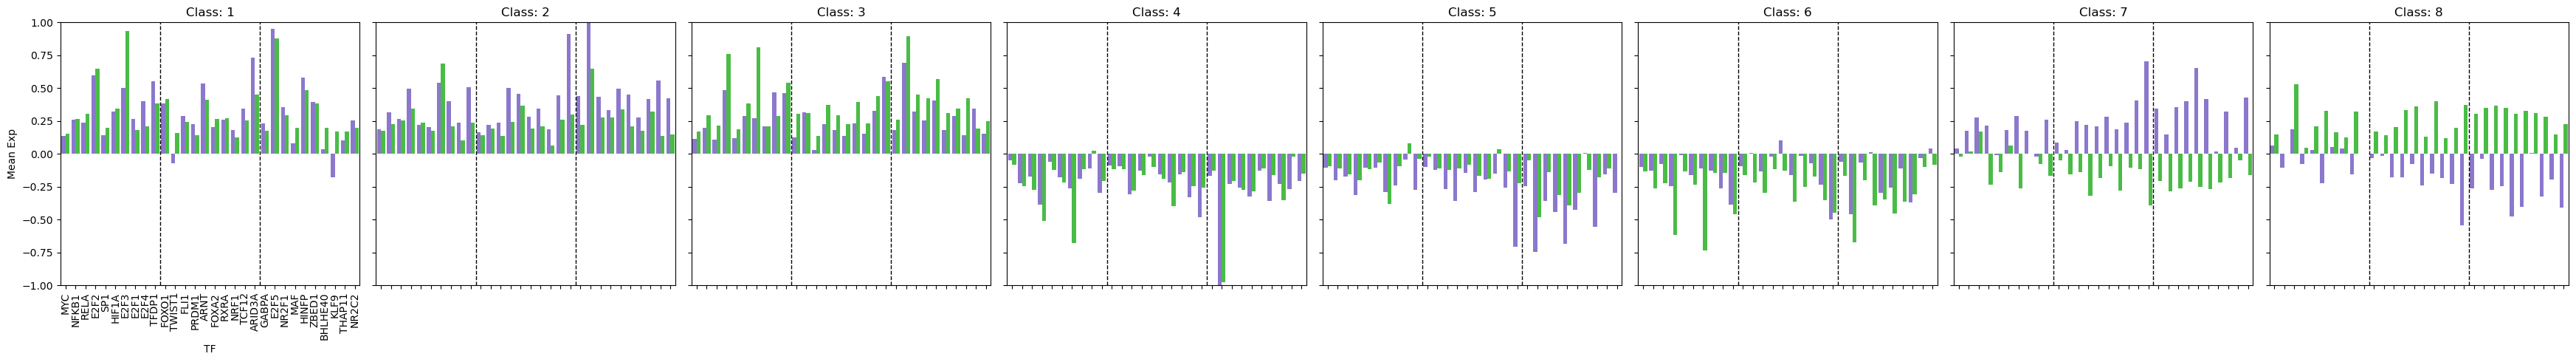

In [57]:
# Melt df_results_sorted for the sizes
df_melted_mean = pd.melt(df_results_sig_sorted, id_vars=['tf', 'tf_group', 'class'], value_vars=['mean_collectri_mean', 'mean_dorothea_mean'], 
                    var_name='dataset', value_name='mean_expression')

# Create a grid of plots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 5))

cmap = ["#836ada", "#38cf33"]

# Iterate through each class and plot
for i, (cls, grp) in enumerate(df_melted_mean.groupby('class')):
    ax = axes[i]
    sns.barplot(data=grp, x='tf', y='mean_expression', hue='dataset', ax=ax, palette=cmap)
    ax.set_title(f'Class: {cls}')
    ax.set_ylim([-1, 1])

    # Only show x-axis labels and y-axis labels on the first plot
    if i != 0:
        ax.set_xlabel('')  # Remove the x-axis label
        ax.set_ylabel('')  # Remove the y-axis label
        ax.tick_params(labelbottom=False, labelleft=False)  # Remove the ticks
    else:
        ax.set_ylabel('Mean Exp')  # Only set for the first plot
        ax.set_xlabel('TF')  # Only set for the first plot

    ax.get_legend().remove()  # Remove the legend from all subplots
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Set rotation for all x-ticks
    
    # Draw vertical lines on every 10 bars
    ax.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=19.5, color='black', linestyle='--', linewidth=1)

# # Add a legend outside the subplots
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

plt.tight_layout()
plt.show()


#### Plot Jaccard, regulons, weight - boxplot - significant aggregate

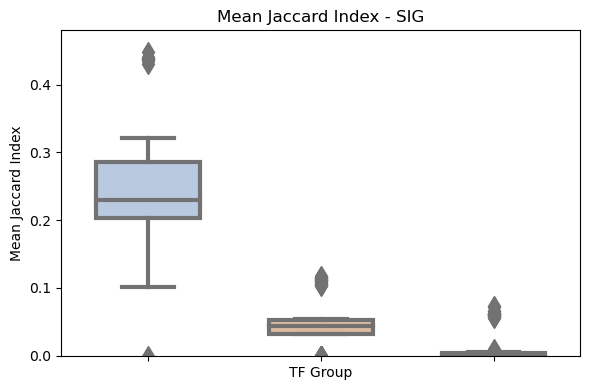

In [58]:
# Define the custom color palette
custom_palette = ["#B1C8E7", "#E6B996", "#A5D7AA"]

# Create a single boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

# Plotting the boxplot
sns.boxplot(data=df_results_sig_sorted, x='tf_group', y='mean_jaccard', 
            palette=custom_palette, width=0.6, fliersize=10, linewidth=3)

plt.title('Mean Jaccard Index - SIG')
plt.ylabel('Mean Jaccard Index')
plt.xlabel('TF Group')
plt.ylim([0, 0.48])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.show()


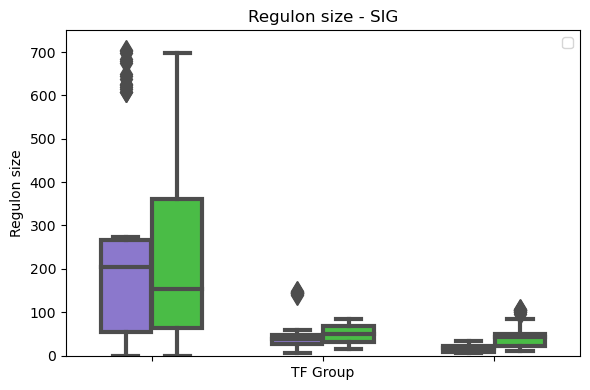

In [59]:
# Reshape the DataFrame to long format
df_long = df_results_sig_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['size_collectri_mean', 'size_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)

plt.title('Regulon size - SIG')
plt.ylabel('Regulon size')
plt.xlabel('TF Group')
plt.ylim([0, 750])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()


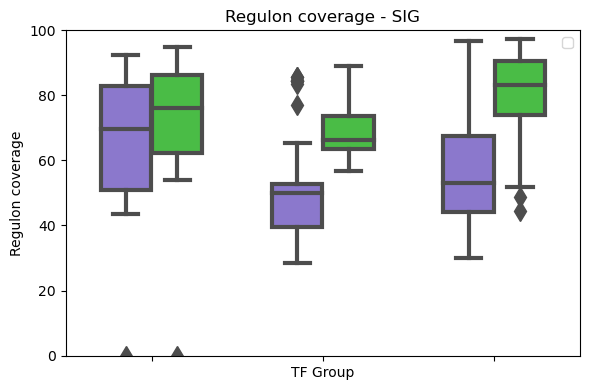

In [60]:
# Reshape the DataFrame to long format
df_long = df_results_sig_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['contribute_collectri_mean', 'contribute_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)

plt.title('Regulon coverage - SIG')
plt.ylabel('Regulon coverage')
plt.xlabel('TF Group')
plt.ylim([0, 100])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()

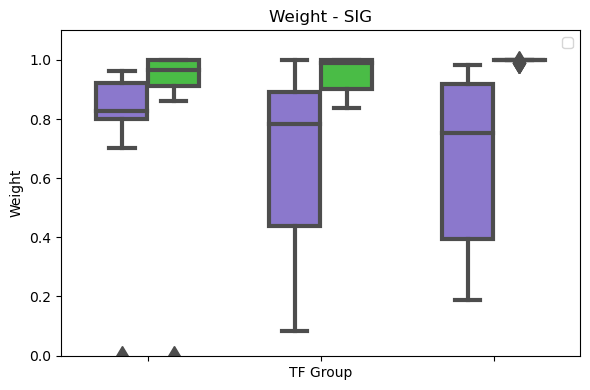

In [61]:
# Reshape the DataFrame to long format
df_long = df_results_sig_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['weight_collectri_mean', 'weight_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)

plt.title('Weight - SIG')
plt.ylabel('Weight')
plt.xlabel('TF Group')
plt.ylim([0, 1.1])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()


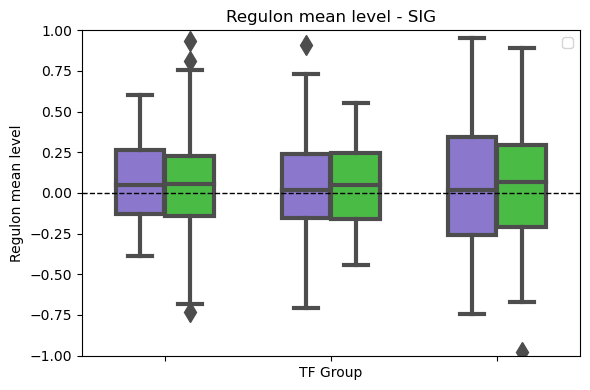

In [62]:
# Reshape the DataFrame to long format
df_long = df_results_sig_sorted.melt(id_vars=['tf_group'], 
                                 value_vars=['mean_collectri_mean', 'mean_dorothea_mean'],
                                 var_name='size_type', value_name='size_mean')

# Define the custom color palette
cmap = ["#836ada", "#38cf33"]

# Create the combined boxplot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.boxplot(data=df_long, x='tf_group', y='size_mean', hue='size_type', 
            palette=cmap, width=0.6, fliersize=10, linewidth=3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Regulon mean level - SIG')
plt.ylabel('Regulon mean level')
plt.xlabel('TF Group')
plt.ylim([-1, 1])  # Adjust the y-axis limit as needed
plt.tick_params(labelbottom=False)  # Remove the ticks
plt.tight_layout()
plt.legend("")
plt.show()


#### Plot Clustergram between TFs and Samples

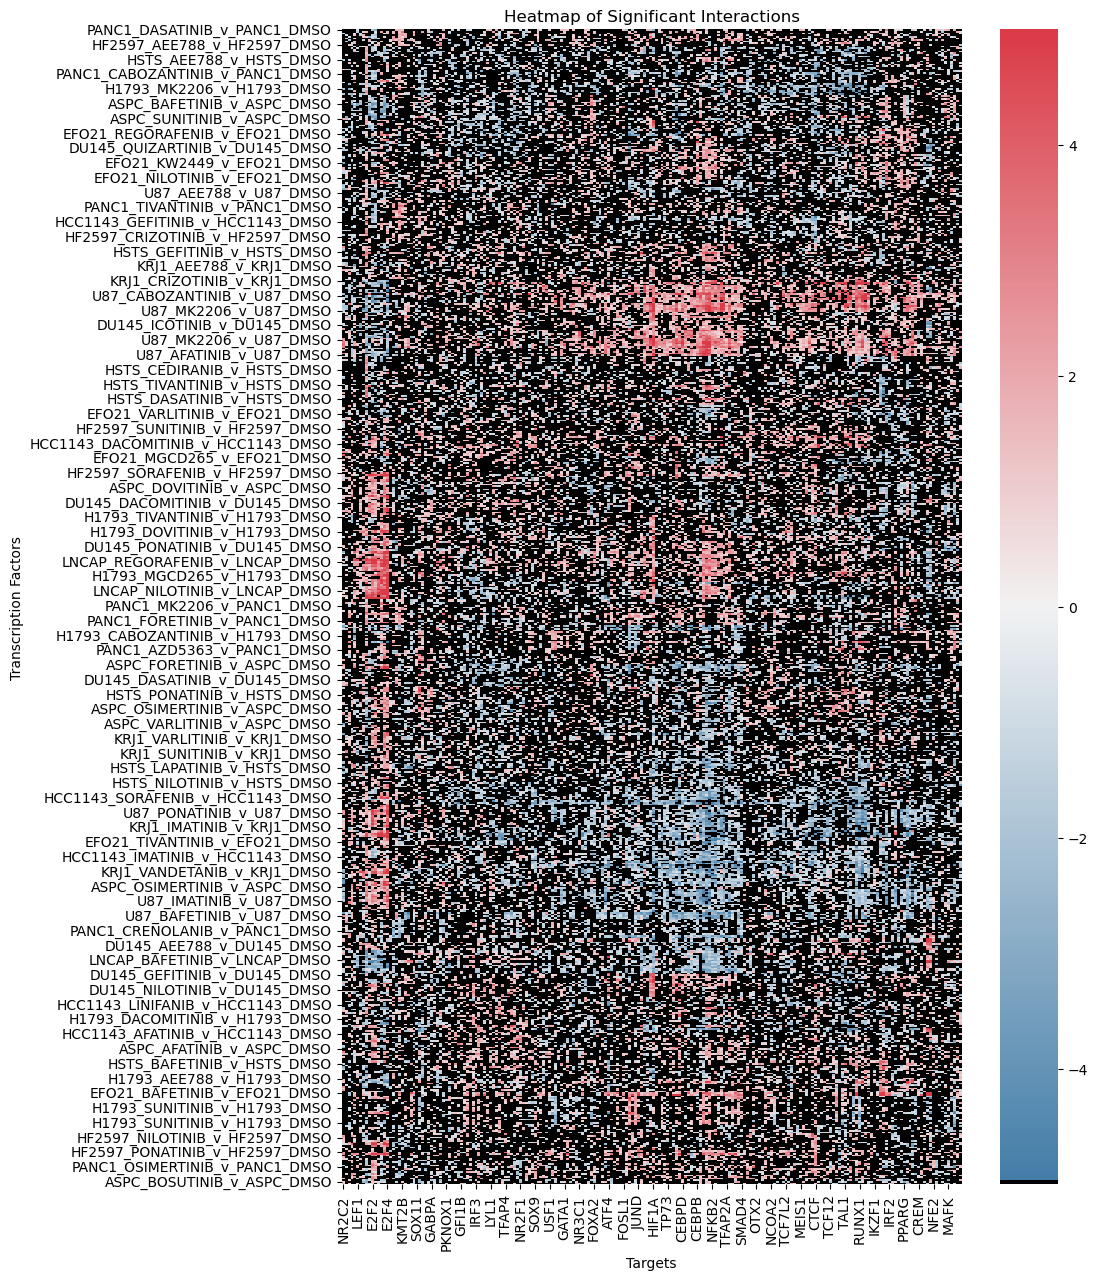

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# Concatenate the original dataframes
df_collectri_acts_overlap_sorted['network'] = 'collectri'
df_dorothea_acts_overlap_sorted['network'] = 'dorothea'
combined_df = pd.concat([
    df_collectri_acts_overlap_sorted,
    df_dorothea_acts_overlap_sorted
], axis=0)

# Extract the 'network' column for row colors
row_colors = combined_df.pop('network').map({
    'collectri': "#836ada", 
    'dorothea': "#38cf33"
})

# Plot the original clustergram and capture the dendrogram order
clustergrid = sns.clustermap(combined_df, metric='correlation', method='average',
                             row_colors=row_colors, figsize=(10, 15), cmap='RdBu_r',
                             vmin=-5, vmax=5, cbar_pos=(0, 0.95, 0.05, 0.05))

# Capture the row and column order
row_order = clustergrid.dendrogram_row.reordered_ind
col_order = clustergrid.dendrogram_col.reordered_ind

plt.close()  # Close the original plot

# Mask non-significant values
extreme_value = -6
mask = df_classes_sig != 3  # Assuming class 3 is both-significant
df_collectri_acts_filtered_sorted_masked = df_collectri_acts_overlap_sorted.where(~mask, extreme_value)
df_dorothea_acts_filtered_sorted_masked = df_dorothea_acts_overlap_sorted.where(~mask, extreme_value)

# Reorder masked dataframes to match the original clustergram order
combined_masked_df = pd.concat([
    df_collectri_acts_filtered_sorted_masked,
    df_dorothea_acts_filtered_sorted_masked
], axis=0)

combined_masked_df_reordered = combined_masked_df.iloc[row_order, :]
combined_masked_df_reordered = combined_masked_df_reordered.iloc[:, col_order]

# Create a custom colormap with black for the extreme value and white at zero
cmap = sns.diverging_palette(240, 10, as_cmap=True)
newcolors = cmap(np.linspace(0, 1, 256))
black = np.array([0/256, 0/256, 0/256, 1])
white = np.array([255/256, 255/256, 255/256, 1])

# Set black for extreme values and white for the center
midpoint = int(256 * (5 - extreme_value) / (10))  # Calculate the midpoint index
newcolors[:1, :] = black
newcolors[midpoint - 1:midpoint + 1, :] = white
newcmp = mcolors.ListedColormap(newcolors)

# Plot the heatmap with the reordered, masked data
plt.figure(figsize=(10, 15))
ax = sns.heatmap(combined_masked_df_reordered, cmap=newcmp, vmin=-5, vmax=5, center=0)
ax.set_title("Heatmap of Significant Interactions")
ax.set_xlabel("Targets")
ax.set_ylabel("Transcription Factors")

plt.show()


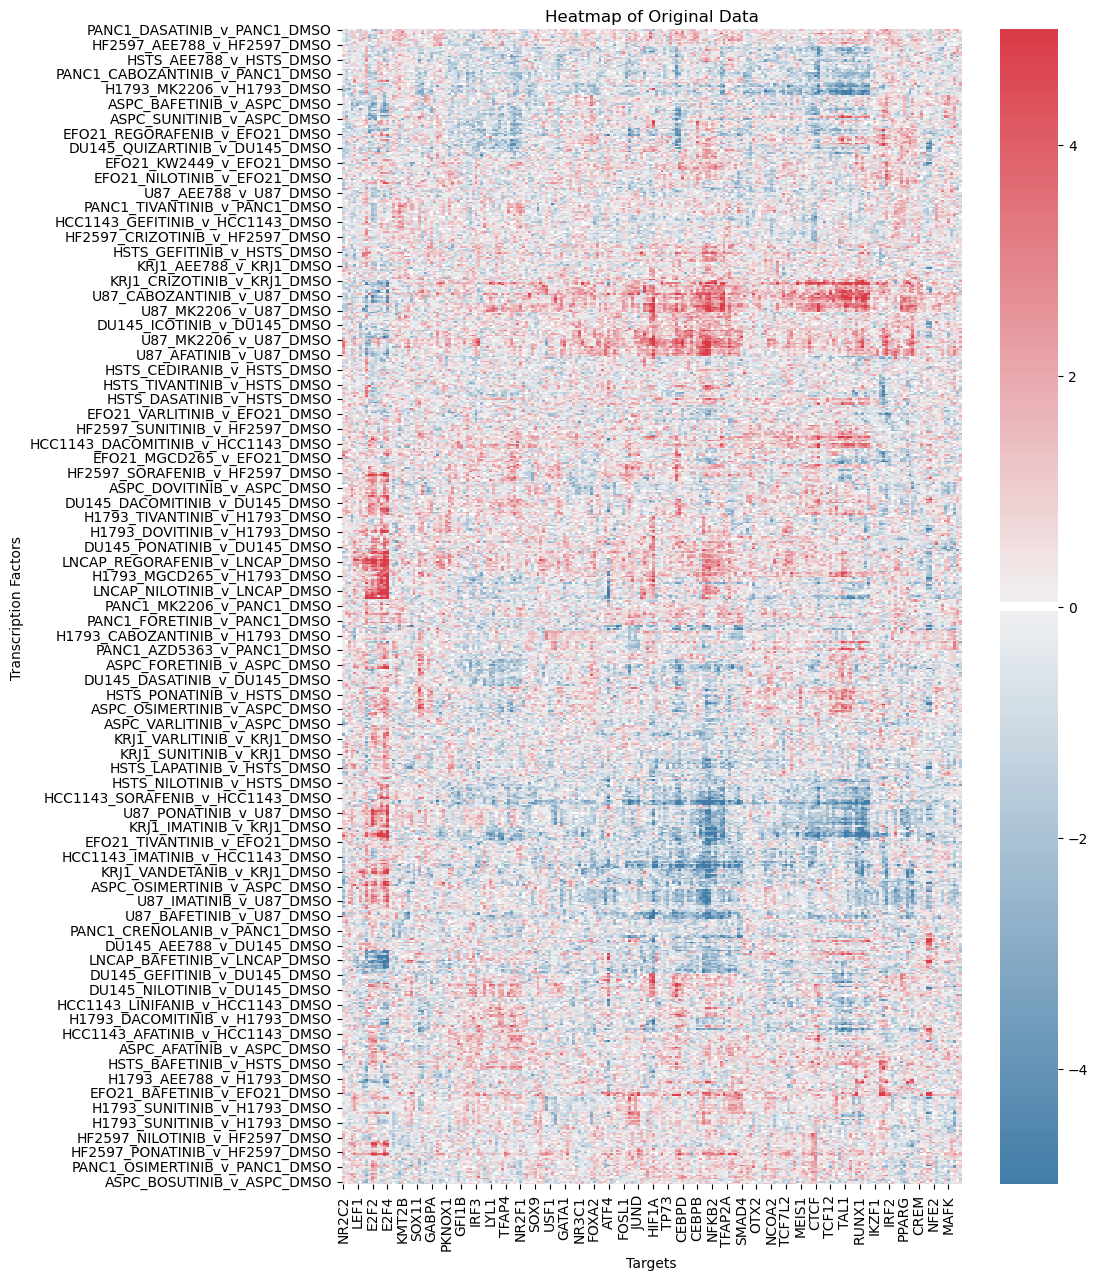

In [64]:
# Concatenate the original dataframes
df_collectri_acts_overlap_sorted['network'] = 'collectri'
df_dorothea_acts_overlap_sorted['network'] = 'dorothea'
combined_df = pd.concat([
    df_collectri_acts_overlap_sorted,
    df_dorothea_acts_overlap_sorted
], axis=0)

# Extract the 'network' column for row colors
row_colors = combined_df.pop('network').map({
    'collectri': "#836ada", 
    'dorothea': "#38cf33"
})

# Plot the original clustergram and capture the dendrogram order
clustergrid = sns.clustermap(combined_df, metric='correlation', method='average',
                             row_colors=row_colors, figsize=(10, 15), cmap='RdBu_r',
                             vmin=-5, vmax=5, cbar_pos=(0, 0.95, 0.05, 0.05))

# Capture the row and column order
row_order = clustergrid.dendrogram_row.reordered_ind
col_order = clustergrid.dendrogram_col.reordered_ind

plt.close()  # Close the original plot

# Reorder original dataframes to match the original clustergram order
combined_df_reordered = combined_df.iloc[row_order, :]
combined_df_reordered = combined_df_reordered.iloc[:, col_order]

# Create a custom colormap with white at zero
cmap = sns.diverging_palette(240, 10, as_cmap=True)
newcolors = cmap(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])

# Set white for the center
midpoint = 128  # Center index for 256 colors
newcolors[midpoint - 1:midpoint + 1, :] = white
newcmp = mcolors.ListedColormap(newcolors)

# Plot the heatmap with the reordered original data
plt.figure(figsize=(10, 15))
ax = sns.heatmap(combined_df_reordered, cmap=newcmp, vmin=-5, vmax=5, center=0)
ax.set_title("Heatmap of Original Data")
ax.set_xlabel("Targets")
ax.set_ylabel("Transcription Factors")

plt.show()
